In [581]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMPORTS

In [582]:
from copy import deepcopy, copy
from hdbscan import all_points_membership_vectors, HDBSCAN
from matplotlib.axes import Axes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Optional
from umap import UMAP
from upsetplot import from_memberships, plot, UpSet, from_indicators, from_contents
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy


from project_modules.clustering import make_feature_importance_df, make_topN_features, make_plot_df

from project_modules.clustering import plot_feature_importances, plot_clusters, plot_multiple_features

# colour palette work
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [583]:
# parameters and dicts

# heatmap parameters
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}
# from the data dictionary
site_fullname_int_dict = {
                  1: "London",
                  2: "Montreal",
                  3: "San Diego",
                  4: "Rio de Janeiro",
                  5: "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

In [584]:
# input and output paths


from pathlib import Path

p = Path('/Users/david/projects/lc2-1028/')
dfile = p / '1028-features.arrow'


figdir    = p
reportdir = "../lc2-report"
data_dir  = "../lc-1028"

# data_dir  = "../lc-project-data"

## FUNCTIONS

In [585]:
# TODO: move these to a module


In [586]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [587]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    # if keep_features == True:
    #     pass
    # else:
    #     df2 = df2.set_index(list(new_df.columns))

    return df2

In [588]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    # figsize = (6,64),
                    ax = None,
                    cmap = cc.cm.bjy,
                    top_n = None,
                    ):
#===============================================================================

    # TODO: colour map to match the cluster thumbnails
    # TODO: drop age, sex

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if top_n is not None:
        mm = mm[:top_n]

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        # cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    # cmap = cc.bjy, 
                    cmap = cmap,
                    ax = ax, 
                    cbar = False, 
                    vmin = 0, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

## LOAD DATA

In [589]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")


# load the dataset from disk
ds_all = Dataset.load_from_disk(dfile)
ds     = Dataset.load_from_disk(dfile)

In [590]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()
df

sex   age  dag  SYMPT-abdominal_pain___1  SYMPT-abdominal_pain___2  \
0     1.0  47.0  1.0                       0.0                       1.0   
1     2.0  37.0  1.0                       0.0                       0.0   
2     2.0  54.0  1.0                       0.0                       0.0   
3     1.0  78.0  1.0                       0.0                       0.0   
4     2.0  33.0  1.0                       0.0                       0.0   
...   ...   ...  ...                       ...                       ...   
1023  2.0  63.0  1.0                       0.0                       0.0   
1024  2.0  69.0  1.0                       0.0                       0.0   
1025  2.0  31.0  1.0                       0.0                       0.0   
1026  2.0  26.0  1.0                       0.0                       0.0   
1027  2.0  45.0  1.0                       0.0                       0.0   

      SYMPT-chest_pain___1  SYMPT-chest_pain___2  \
0                      0.0                   0.0   
1                      0.0                   0.0   
2                      0.0                   0.0   
3                      0.0                   0.0   
4                      1.0                   0.0   
...                    ...                   ...   
1023                   0.0                   0.0   
1024                   0.0                   0.0   
1025                   0.0                   0.0   
1026                   0.0                   0.0   
1027                   0.0                   0.0   

      SYMPT-confusion_altered_mental_s___1  \
0                                      0.0   
1                                      1.0   
2                                      1.0   
3                                      0.0   
4                                      1.0   
...                                    ...   
1023                                   0.0   
1024                                   0.0   
1025                                   0.0   
1026                                   0.0   
1027                                   0.0   

      SYMPT-confusion_altered_mental_s___2  SYMPT-cough___1  ...  \
0                                      1.0              1.0  ...   
1                                      0.0              1.0  ...   
2                                      1.0              1.0  ...   
3                                      0.0              0.0  ...   
4                                      1.0              1.0  ...   
...                                    ...              ...  ...   
1023                                   0.0              0.0  ...   
1024                                   0.0              0.0  ...   
1025                                   0.0              0.0  ...   
1026                                   0.0              0.0  ...   
1027                                   0.0              0.0  ...   

      CD-ventilatory_support_type___1  CD-ventilatory_support_type___2  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   
...                               ...                              ...   
1023                              0.0                              0.0   
1024                              0.0                              0.0   
1025                              0.0                              0.0   
1026                              0.0                              0.0   
1027                              0.0                              0.0   

      CD-ventilatory_support_type___3  CD-ventilatory_support_type___4  \
0                                 0.0                              0.0   
1                                 0.0                        

In [591]:
# import good feature names
feature_map_df = pd.read_csv(f"./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict
import json

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(f"{len(feature_map)} features loaded.")
print(f"{len(feature_colour_map)} colours loaded.")

99 features loaded.
86 colours loaded.


In [592]:
cc.glasbey_hv[100:105]


[[0.643137, 0.152941, 0.129412],
 [0.113725, 0.894118, 1.0],
 [0.490196, 0.686275, 0.231373],
 [0.482353, 0.294118, 0.568627],
 [0.878431, 1.0, 0.282353]]

## LC+, LC-, HC

### Select which sets of features to use

In [593]:
LC_pos = df.query('LC_STATUS == 1').copy() # type: ignore
LC_neg = df.query('LC_STATUS == 0').copy() # type: ignore 
HC     = df.query('LC_STATUS == 2').copy()     # type: ignore

In [594]:
LC_pos.shape, LC_neg.shape, HC.shape

((494, 354), (494, 354), (40, 354))

In [595]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass
LC_pos

sex   age  dag  SYMPT-abdominal_pain___1  SYMPT-abdominal_pain___2  \
0    1.0  47.0  1.0                       0.0                       1.0   
1    2.0  37.0  1.0                       0.0                       0.0   
2    2.0  54.0  1.0                       0.0                       0.0   
3    1.0  78.0  1.0                       0.0                       0.0   
4    2.0  33.0  1.0                       0.0                       0.0   
..   ...   ...  ...                       ...                       ...   
978  1.0  25.0  5.0                       0.0                       0.0   
979  1.0  51.0  5.0                       0.0                       0.0   
980  1.0  50.0  5.0                       0.0                       0.0   
981  1.0  71.0  4.0                       0.0                       0.0   
982  2.0  68.0  4.0                       0.0                       0.0   

     SYMPT-chest_pain___1  SYMPT-chest_pain___2  \
0                     0.0                   0.0   
1                     0.0                   0.0   
2                     0.0                   0.0   
3                     0.0                   0.0   
4                     1.0                   0.0   
..                    ...                   ...   
978                   1.0                   0.0   
979                   0.0                   0.0   
980                   1.0                   1.0   
981                   0.0                   0.0   
982                   0.0                   0.0   

     SYMPT-confusion_altered_mental_s___1  \
0                                     0.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     1.0   
..                                    ...   
978                                   0.0   
979                                   0.0   
980                                   0.0   
981                                   0.0   
982                                   0.0   

     SYMPT-confusion_altered_mental_s___2  SYMPT-cough___1  ...  \
0                                     1.0              1.0  ...   
1                                     0.0              1.0  ...   
2                                     1.0              1.0  ...   
3                                     0.0              0.0  ...   
4                                     1.0              1.0  ...   
..                                    ...              ...  ...   
978                                   0.0              1.0  ...   
979                                   0.0              0.0  ...   
980                                   0.0              1.0  ...   
981                                   0.0              0.0  ...   
982                                   0.0              0.0  ...   

     CD-type_of_care___2  CD-ventilatory_support_type___1  \
0                    0.0                              0.0   
1                    0.0                              0.0   
2                    0.0                              0.0   
3                    0.0                              0.0   
4                    0.0                              0.0   
..                   ...                              ...   
978                  1.0                              0.0   
979                  0.0                              0.0   
980                  0.0                              0.0   
981                  0.0                              0.0   
982                  0.0                              0.0   

     CD-ventilatory_support_type___2  CD-ventilatory_support_type___3  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0           

In [596]:
# make a list of the columns
ftrs = list(df.columns)

# how many features start with one of ["SYMP", "CD", "MED"]?

for sw in ["SYMP", "CD", "MED", "VAX", "HHX", "IMG","LAB", "SUBS"]:
    print(sw, len([f for f in ftrs if f.startswith(sw)]))

SYMP 56
CD 244
MED 0
VAX 1
HHX 49
IMG 0
LAB 0
SUBS 0


# CLUSTERING

In [597]:
# clustering

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [598]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = df["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = df["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


# drop dag
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'dag').columns)

# drop columns that start with CD and end with ___1
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD.*___1').columns)

print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(494, 154)
(494, 154)


In [599]:
# get a list of all features that start with CD- and end with ___1
# these are the initial covid symptoms
new_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___1")]

new_symptoms = []

# get a list of all features that start with CD- and end with ___2
# these are the follow-up covid symptoms
worse_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___2")]

lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

new_and_worse = new_symptoms + worse_symptoms + lc_symptoms
new_and_worse = lc_symptoms

In [600]:
# sort new_and_worse
new_and_worse = sorted(new_and_worse)

In [601]:
# drop SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_)     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

In [602]:
X.shape

(494, 154)

In [603]:
sites = df["dag"].apply(lambda x: site_name_dict[x])


# use only the sites with indices in the LC_pos_ dataframe
sites = sites.loc[LC_pos_.index]
sites.shape


(494,)

In [604]:
sites

0      LDN
1      LDN
2      LDN
3      LDN
4      LDN
      ... 
978    LUS
979    LUS
980    LUS
981    RIO
982    RIO
Name: dag, Length: 494, dtype: object

## Use UMAP to visualize the data and cluster

### Handling missing values

In [605]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 1)

print(X.shape)

(494, 139)


### EMBED and CLUSTER

In [606]:
# pipeline for scaling, embedding, and clustering 

# min cluster size scales as sqrt(n)
min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
                # 'metric': 'hamming',
            }

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', UMAP(**umap_parms, verbose = True)),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# # TODO: move this to a function
# points   = pipe["embed"].embedding_
# clusters = pipe["cluster"].labels_
# probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
#                            axis = 1)

# clusters = cluster_labels


# plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
# plot_df["Cluster"]            = [c+1 for c in clusters]
# plot_df["Cluster Confidence"] = probs
# plot_df["Site"]               = sites

plot_df, cluster_labels = make_plot_df(pipe, 
                                        sites,
                                        site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100


UMAP(random_state=42, spread=5.0, verbose=True)
Tue Jul 23 09:48:17 2024 Construct fuzzy simplicial set
Tue Jul 23 09:48:17 2024 Finding Nearest Neighbors
Tue Jul 23 09:48:17 2024 Finished Nearest Neighbor Search
Tue Jul 23 09:48:17 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jul 23 09:48:18 2024 Finished embedding


In [607]:
plot_df

x          y  Cluster  Cluster Confidence Site
0    -8.188618  -4.138154        5            0.000000  LDN
1    -0.736281  -3.295812        5            0.000000  LDN
2    -8.838879  12.781908        1            0.000000  LDN
3     8.202627   9.348203        2            0.000000  LDN
4    -3.781357   7.194489        6            1.000000  LDN
..         ...        ...      ...                 ...  ...
978  16.012541   4.069829        3            1.000000  LUS
979   9.664495   5.656536        4            0.000000  LUS
980  10.881226  -6.232446        3            0.000000  LUS
981  13.892166   8.298031        3            0.907439  RIO
982  -0.691458  -2.446299        5            0.000000  RIO

[494 rows x 5 columns]

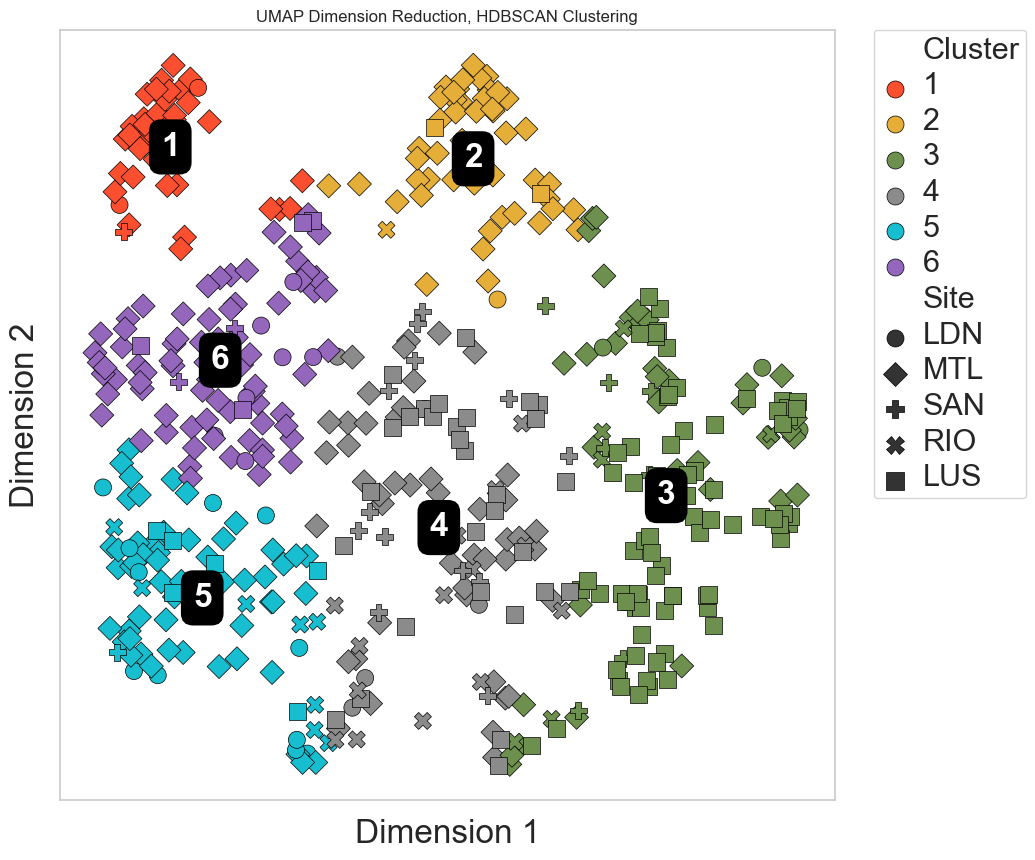

In [608]:
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title        = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids    = True, 
              size_by_prob = False, 
              ax           = None,
              centroid_kws = {"alpha": 1.0, "palette_dict":None, "show_edge": False},)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

#### Cluster by Site

In [609]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site.copy()

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# sort the index by the order in site_name_dict
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster     1     2     3     4     5     6
Site                                       
LDN       2.0   1.0   3.0   4.0  11.0   8.0
MTL      35.0  48.0  35.0  47.0  55.0  73.0
SAN       1.0   0.0   8.0  14.0   1.0   2.0
RIO       0.0   1.0   6.0  14.0   8.0   0.0
LUS       0.0   2.0  75.0  30.0   6.0   4.0


In [610]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/basic-cluster-by-site.tex")

In [611]:
c1 = plot_df.groupby("Cluster")["Site"].value_counts(normalize = True).unstack().T.fillna(0)#.astype(int)
c1 = c1.loc[site_name_dict.values()]
c1

Cluster         1         2         3         4         5         6
Site                                                               
LDN      0.052632  0.019231  0.023622  0.036697  0.135802  0.091954
MTL      0.921053  0.923077  0.275591  0.431193  0.679012  0.839080
SAN      0.026316  0.000000  0.062992  0.128440  0.012346  0.022989
RIO      0.000000  0.019231  0.047244  0.128440  0.098765  0.000000
LUS      0.000000  0.038462  0.590551  0.275229  0.074074  0.045977

#### RFC Model to identify features that differentiate clusters

In [612]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )



# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 90
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	24
Tentative: 	0
Rejected: 	115


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=101,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x326B6AF40),
         n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x326B6AF40, verbose=1)

In [613]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=101, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x326B6AF40)

In [614]:
fi_df1 = make_feature_importance_df(clf, important_features)
features20 = make_topN_features(fi_df1, 10, feature_map, feature_colour_map)


In [615]:
fi_df1, features20

Feature  Importance
0                SYMPT-shortness_of_breath_dyspne___2    0.170910
1                                   SYMPT-fatigue___2    0.104598
2                SYMPT-loss_of_taste_lost_of_smel___2    0.103375
3                                                 sex    0.083250
4                                      HHX-OTHER-hypo    0.082421
5                                                 age    0.067974
6                      SYMPT-muscle_aches_myalgia___2    0.049934
7                     SYMPT-joint_pain_arthralgia___2    0.049182
8                                           HHX-Other    0.043177
9                                SYMPT-chest_pain___2    0.036058
10                                    SYMPT-cough___2    0.030505
11                                 SYMPT-headache___2    0.022666
12                                         HHX-Asthma    0.022450
13                                SYMPT-dizziness___2    0.020785
14               SYMPT-extremity_weakness_or_numb___2    0.016013
15                          HHX-Arterial Hypertension    0.015848
16               SYMPT-confusion_altered_mental_s___2    0.013670
17                                      HHX-OTHER-MSK    0.012716
18                                    HHX-HIV or AIDS    0.010807
19  HHX-Chronic neurological disorder (other than ...    0.009885
20                           SYMPT-abdominal_pain___2    0.009701
21               SYMPT-trouble_speaking_aphasia_d___2    0.008796
22                    SYMPT-runny_nose_rhinorrhea___2    0.008599
23                                CD-type_of_care___2    0.006678

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


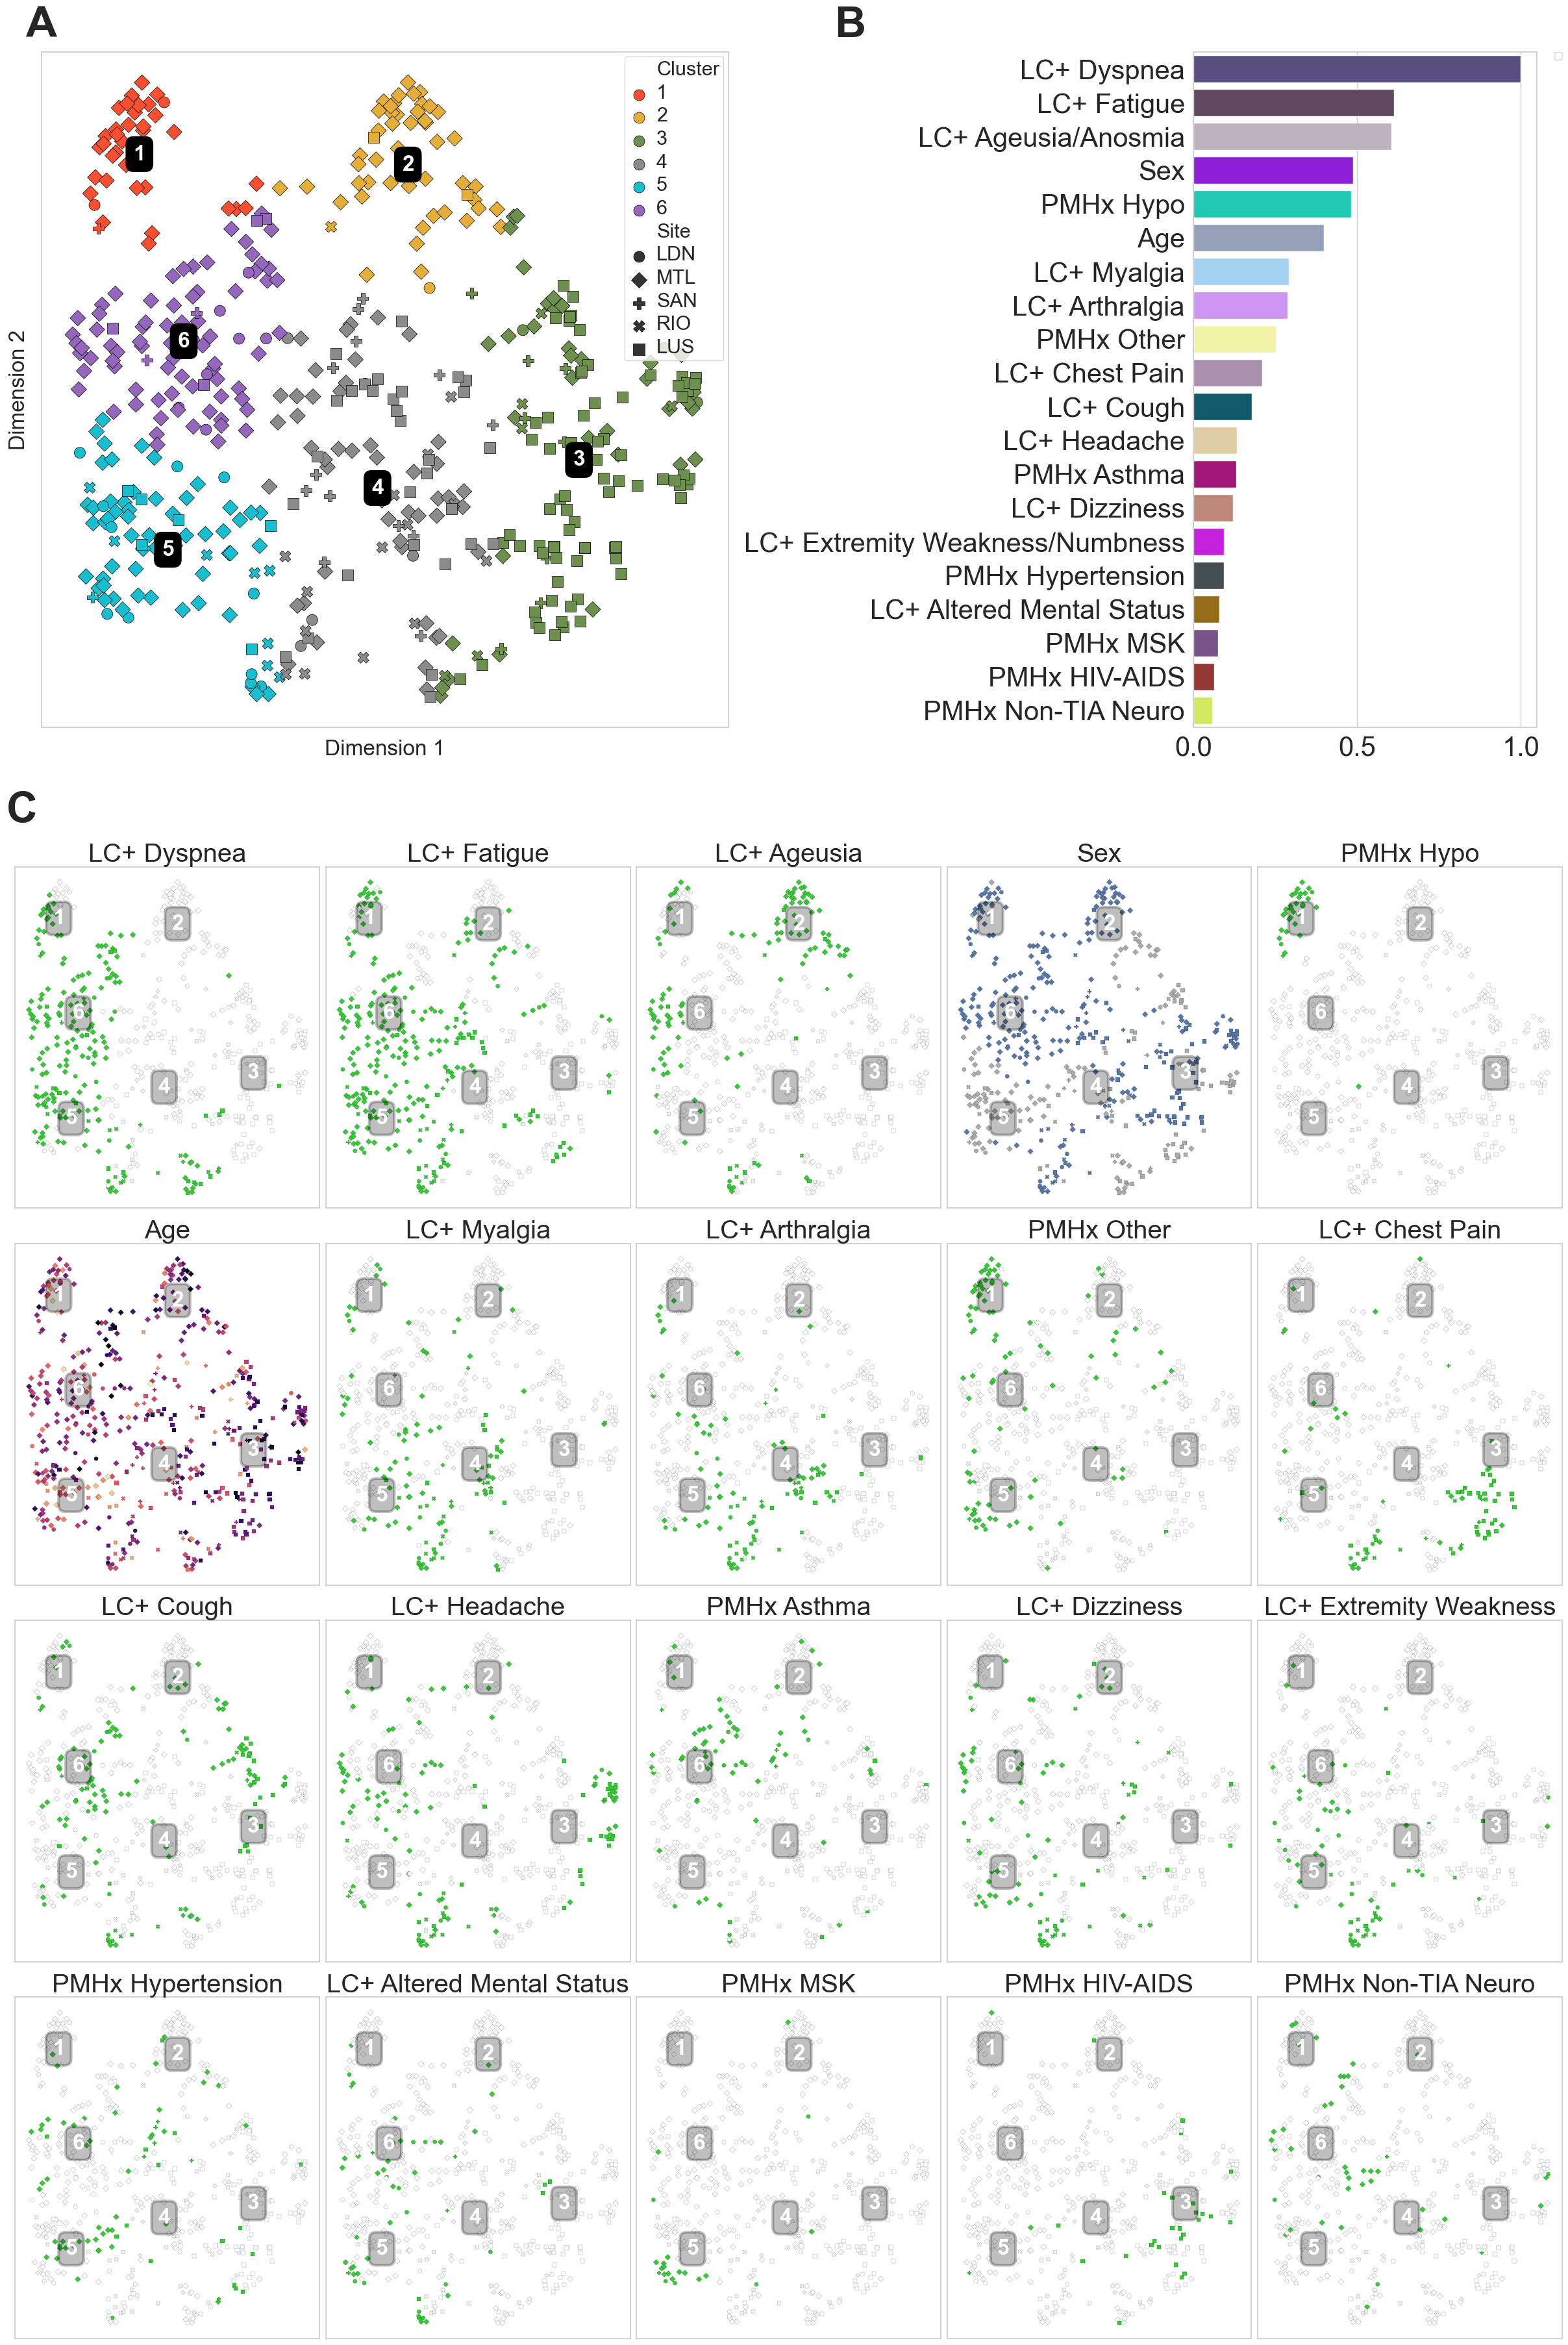

In [546]:
fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, palette_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )

plot_feature_importances(features20, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(fi_df1, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        fontsize = FONTSIZE*1.2,
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:
    # plt.savefig(f"{figdir}/feature-importances-600.png", dpi = 600, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/feature-importances-300.png", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

### Excursion Plots

In [547]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# fi_df = make_feature_importance_df(clf, important_features)

# make a table of all of the features and their rankings
fff = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
fff["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in fff.iterrows():
    if f["Importance"] == True:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
fff.sort_values(by = "FI", ascending = False, inplace = True)

In [548]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[fff["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [549]:
cluster_by_site

Cluster     1     2     3     4     5     6
Site                                       
LDN       2.0   1.0   3.0   4.0  11.0   8.0
MTL      35.0  48.0  35.0  47.0  55.0  73.0
SAN       1.0   0.0   8.0  14.0   1.0   2.0
RIO       0.0   1.0   6.0  14.0   8.0   0.0
LUS       0.0   2.0  75.0  30.0   6.0   4.0

In [550]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

cbsm

cluster            1     2     3     4     5     6
Site                                              
London           6.9   3.4  10.3  13.8  37.9  27.6
Montreal        11.9  16.4  11.9  16.0  18.8  24.9
San Diego        3.8   0.0  30.8  53.8   3.8   7.7
Rio de Janeiro   0.0   3.4  20.7  48.3  27.6   0.0
Lusaka           0.0   1.7  64.1  25.6   5.1   3.4

In [551]:
zzz = M.groupby("cluster").mean()

# get the first 20 columns
zzz = zzz[fff["Feature"][:20]]

# rename the columns
for c in zzz.columns:
    zzz.rename(columns = {c: feature_map[c]}, inplace = True)

# drop age and sex
zzz = zzz.drop(columns = ["Age", "Sex"])

In [552]:
zzz

LC+ Dyspnea  LC+ Fatigue  LC+ Ageusia/Anosmia  PMHx Hypo  \
cluster                                                             
1           0.684211     0.657895             0.289474   0.815789   
2           0.038462     0.346154             0.961538   0.000000   
3           0.110236     0.149606             0.039370   0.000000   
4           0.146789     0.504587             0.082569   0.009174   
5           0.839506     1.000000             0.259259   0.000000   
6           0.977011     0.827586             0.287356   0.000000   

         LC+ Myalgia  LC+ Arthralgia  PMHx Other  LC+ Chest Pain  LC+ Cough  \
cluster                                                                       
1           0.263158        0.157895    0.894737        0.078947   0.210526   
2           0.096154        0.038462    0.153846        0.038462   0.192308   
3           0.023622        0.015748    0.039370        0.338583   0.322835   
4           0.394495        0.412844    0.055046        0.146789   0.119266   
5           0.432099        0.370370    0.320988        0.148148   0.259259   
6           0.172414        0.137931    0.149425        0.057471   0.436782   

         LC+ Headache  PMHx Asthma  LC+ Dizziness  \
cluster                                             
1            0.157895     0.131579       0.157895   
2            0.115385     0.153846       0.134615   
3            0.283465     0.062992       0.055118   
4            0.211009     0.091743       0.183486   
5            0.296296     0.098765       0.370370   
6            0.321839     0.367816       0.206897   

         LC+ Extremity Weakness/Numbness  PMHx Hypertension  \
cluster                                                       
1                               0.052632           0.052632   
2                               0.019231           0.134615   
3                               0.031496           0.078740   
4                               0.165138           0.146789   
5                               0.320988           0.283951   
6                               0.137931           0.149425   

         LC+ Altered Mental Status  PMHx MSK  PMHx HIV-AIDS  \
cluster                                                       
1                         0.105263  0.000000       0.026316   
2                         0.038462  0.038462       0.019231   
3                         0.023622  0.000000       0.165354   
4                         0.073394  0.018349       0.036697   
5                         0.234568  0.197531       0.024691   
6                         0.183908  0.011494       0.000000   

         PMHx Non-TIA Neuro  
cluster                      
1                  0.210526  
2                  0.019231  
3                  0.031496  
4                  0.100917  
5                  0.061728  
6                  0.149425

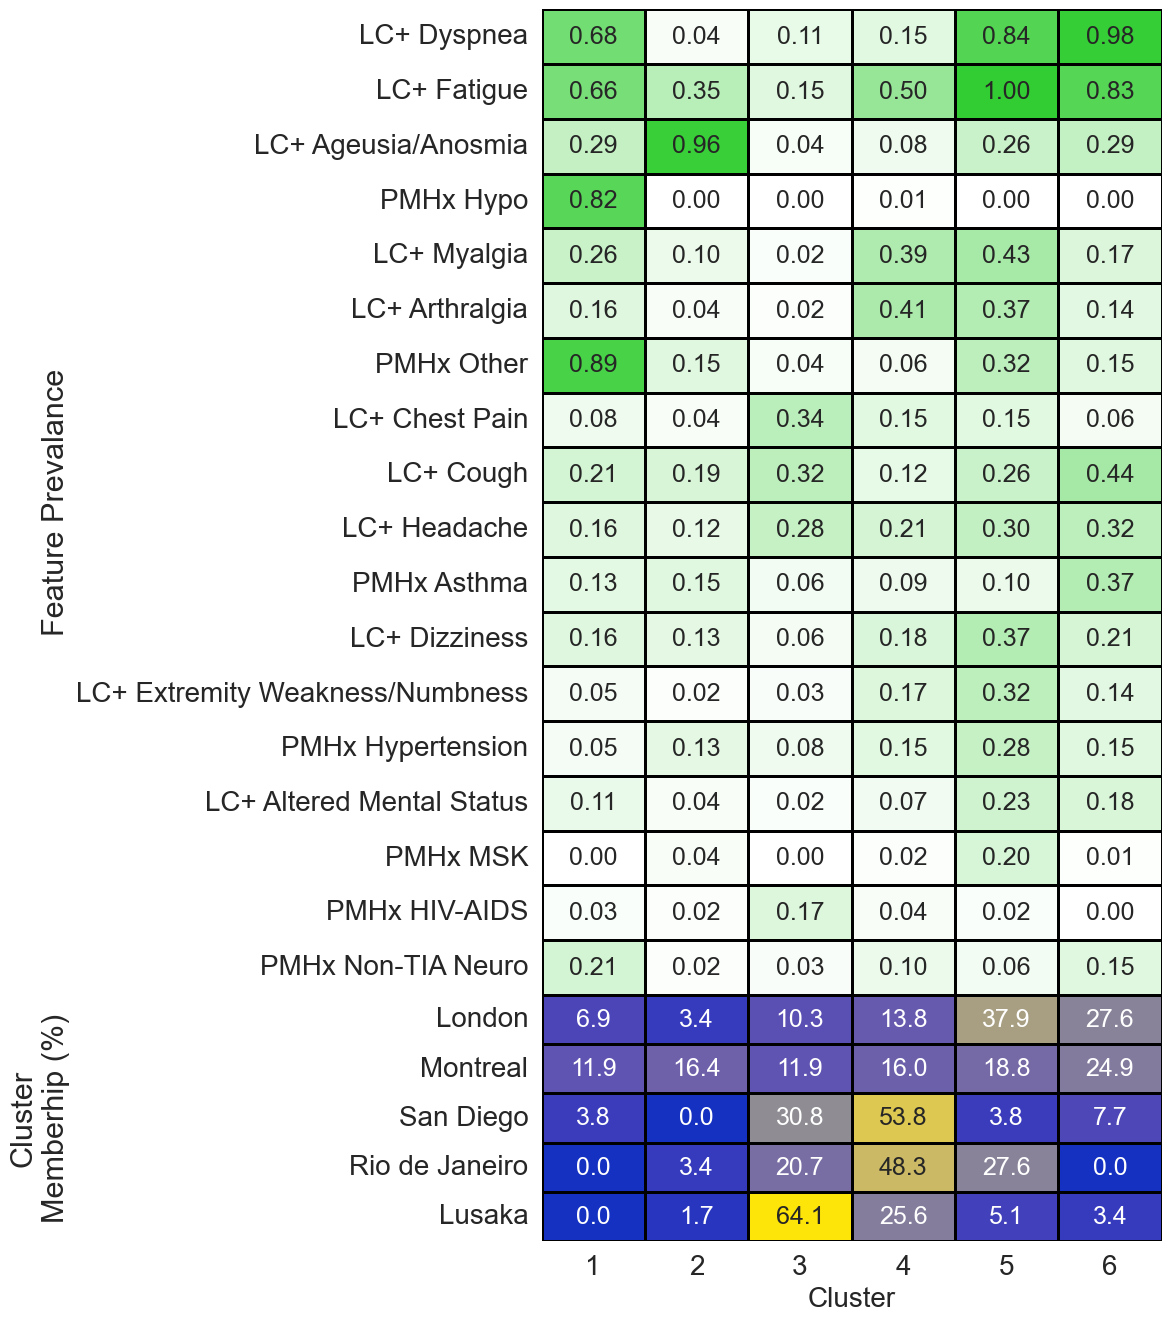

In [553]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(zzz.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
plt.savefig(f"{figdir}/feature-prevalence-by-cluster-600.png", dpi = 600, bbox_inches = 'tight')
plt.savefig(f"{figdir}/feature-prevalence-by-cluster-300.png", dpi = 300, bbox_inches = 'tight')


### UPSET PLOTS

In [554]:
# A["SITE"] = LC_pos_["SITE"]
# II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# # get column names and index names from X 
# II.columns = X.columns
# II.index   = X.index


# # A.shape, X.shape, II.shape
# # vv = A.drop("cluster", axis = 1)
# B = II.copy()

# # augment with site labels
# B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# interesting = list(fff["Feature"][:5])
# upset_A = make_upset_data(A, 
#                        interesting, 
#                        )

# upset_data = make_upset_data(B, 
#                                 interesting, 
#                                 keep_features = True
#                                 )

# indicators_bool = upset_data.select_dtypes(include = ['bool'])
# us = UpSet(
#     from_indicators(indicators_bool, data = upset_data),
#     min_subset_size=15,
#     # max_subset_size=200,
#     show_counts                = True,
#     sort_categories_by         = "-input",
#     subset_size                = "count",
#     intersection_plot_elements = 0,
#     orientation                = "horizontal",
# )

# # us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )

# us.add_stacked_bars(by="SITE", 
#                        title="Count SITE", 
#                        elements=10, 
#                        colors = cc.m_glasbey_hv, 
#                        )

# us.plot()
# plt.show()

In [555]:
# upset = UpSet(upset_A, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 sort_categories_by         = "-input",
#                 show_counts = False, 
#                 intersection_plot_elements = 0,
#                 max_subset_size = 200
#                 )
# # upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# # upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")

# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)


# upset.plot()
# plt.show()

In [556]:
# from scipy.stats import chi2_contingency

# rd = {}

# for site1 in site_name_dict.values():

#     for site2 in site_name_dict.values():

#         for col in X.columns:

#             # get the index of rows where SITE is site1 or site2
#             idx = LC_pos_["SITE"].isin([site1, site2])

#             print(idx)

#             ct = pd.crosstab(LC_pos_.loc[idx]["SITE"], X.loc[idx][col]).rename(index = site_name_dict)


#             print(ct)

#             result = chi2_contingency(ct)
#             if result[1] < 0.05:
#                 # print(ct)
#                 print(f"{site}: \t{col} --> p = {result[1]}")
#                 rd.update({site: result[1]})


# # for col in X.columns:


# #     ct = pd.crosstab(LC_pos_["SITE"], X[col]).rename(index = site_name_dict)

# #     result = chi2_contingency(ct)
# #     if result[1] < 0.05:
# #         # print(ct)
# #         # print(f"{col}: p = {result[1]}")
# #         rd.update({col: result[1]})

# # # make dataframe from rd
# # rd_df = pd.DataFrame.from_dict(rd, orient = "index", columns = ["p-value"])

# # # sort by p-value
# # rd_df.sort_values(by = "p-value", inplace = True, ascending = False)
# # rd_df

# By SITE for subphenotypes at each site

In [574]:
# select the columns to use
LC_COLUMNS = LC_pos_.columns

# remove SITE from LC_COLUMNSb

# LC_COLUMNS = LC_COLUMNS.drop(["SITE", "age"])

# LC_pos_["SITE"] = sites

In [575]:
LC_COLUMNS

Index(['CD-acute_kidney_injury___2', 'CD-acute_respiratory_distress___2',
       'CD-anemia___2', 'CD-anxiety___2', 'CD-asthma___2', 'CD-avpu',
       'CD-baby_covid', 'CD-bacterial_viral_or_cryptog___2',
       'CD-bacteriemia___2', 'CD-bmi',
       ...
       'SYMPT-shortness_of_breath_dyspne___2', 'SYMPT-skin_rash___2',
       'SYMPT-sore_throat___2', 'SYMPT-trouble_speaking_aphasia_d___2',
       'SYMPT-weight_loss___2', 'SYMPT-wheezing_or_stridor___2',
       'VAX-vaccinated', 'age', 'sex', 'SITE'],
      dtype='object', length=155)

In [576]:
LC_pos_["SITE"] = sites

In [578]:
LC_pos_

CD-acute_kidney_injury___2  CD-acute_respiratory_distress___2  \
0                           0.0                                0.0   
1                           0.0                                0.0   
2                           0.0                                0.0   
3                           0.0                                0.0   
4                           0.0                                0.0   
..                          ...                                ...   
978                         0.0                                0.0   
979                         0.0                                0.0   
980                         0.0                                0.0   
981                         0.0                                0.0   
982                         0.0                                0.0   

     CD-anemia___2  CD-anxiety___2  CD-asthma___2  CD-avpu  CD-baby_covid  \
0              0.0             0.0            0.0      1.0            NaN   
1              0.0             0.0            0.0      1.0            NaN   
2              0.0             0.0            0.0      1.0            NaN   
3              0.0             0.0            0.0      1.0            NaN   
4              0.0             0.0            0.0      1.0            NaN   
..             ...             ...            ...      ...            ...   
978            0.0             0.0            0.0      NaN            NaN   
979            0.0             0.0            0.0      NaN            NaN   
980            0.0             0.0            0.0      NaN            NaN   
981            0.0             0.0            0.0      NaN            NaN   
982            0.0             0.0            0.0      NaN            NaN   

     CD-bacterial_viral_or_cryptog___2  CD-bacteriemia___2  CD-bmi  ...  \
0                                  0.0                 0.0    34.3  ...   
1                                  0.0                 0.0    24.9  ...   
2                                  0.0                 0.0    19.5  ...   
3                                  0.0                 0.0    29.9  ...   
4                                  0.0                 0.0    20.4  ...   
..                                 ...                 ...     ...  ...   
978                                0.0                 0.0    24.6  ...   
979                                0.0                 0.0    30.5  ...   
980                                0.0                 0.0    23.0  ...   
981                                0.0                 0.0     NaN  ...   
982                                0.0                 0.0     NaN  ...   

     SYMPT-shortness_of_breath_dyspne___2  SYMPT-skin_rash___2  \
0                                     0.0                  0.0   
1                                     1.0                  0.0   
2                                     1.0                  0.0   
3                                     0.0                  0.0   
4                                     1.0                  0.0   
..                                    ...                  ...   
978                                   0.0                  0.0   
979                                   0.0                  0.0   
980                                   1.0                  0.0   
981                                   0.0                  0.0   
982                                   1.0                  0.0   

     SYMPT-sore_throat___2  SYMPT-trouble_speaking_aphasia_d___2  \
0                      0.0                                   1.0   
1                      0.0                                   0.0   
2                      0.0                                   0.0   
3                      0.0                                   0.0   
4                      0.0                                   1.0   
..                     ...                                   ...   
978                    0.0                                   0.0   
9

In [573]:
# cluster pipeline, iterating over the sites

result_dict = {}

for i, (k,v) in enumerate(site_name_dict.items()):
    # print(i, k, v)

    print(f"Site {k}: {v}")

    q = f"SITE == '{v}'"
    print(q)

    # LC_pos_ = df.query(f"SITE == {k}").copy()
    the_data = LC_pos_.query(f"SITE =='{v}'").copy()

    # drop age
    the_data = the_data.drop(columns = ["age"])
    the_data = the_data.drop(columns = ["SITE"])

    print(the_data.shape)


    X = scaler.fit_transform(the_data)     # type: ignore
    X = X.dropna(axis = 1)
    X = X[LC_COLUMNS]

    print(f"Data shape = {the_data.shape}")
    print(f"X shape    = {X.shape}")


    # reduce and cluster
    # sklearn pipelines
    min_cluster_size = int(np.sqrt(X.shape[0]))

    hdb_parms = {
                    # min_cluster_size is roughly 
                    # sqrt(n) where n is the number of samples
                    'min_cluster_size': min_cluster_size, 
                    'min_samples': min_cluster_size,
                    'cluster_selection_method': 'leaf', # more granular
                    'cluster_selection_epsilon': 0.1,
                }

    umap_parms = {
                    'n_components': 2,
                    'spread':       1.0,
                    'random_state': 42,
                    # 'metric':      'euclidean',
                    # 'metric':      'hamming',
                    'verbose':      False
                }

    # turn off userwarnings from umap
    import warnings
    warnings.filterwarnings("ignore")
    
    # instantiate the pipeline
    pipe = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('embed', UMAP(**umap_parms)),
                    ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                    ])

    # apply to the feature dataframe
    pipe.fit(X)

    # get the plot dataframe and cluster labels
    sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
    plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

    # what fraction of the data is in each cluster?
    # print(plot_df["Cluster"].value_counts(normalize = True)*100)

    # use all cores
    clf = RandomForestClassifier(n_jobs=-1, 
                                #  n_estimators = 100, 
                                #  class_weight='balanced', 
                                max_depth=7
                                )

    # instantiate the Boruta feature selector
    from boruta_py.boruta import BorutaPy

    boruta = BorutaPy(clf, 
                    #   n_estimators = 1_000, 
                    n_estimators = 'auto',
                    verbose      = 0, 
                    random_state = 42, 
                    perc         = 100
                    )
    boruta.fit(X, cluster_labels)

    # make a subset of the data with the important features and 
    # fit a classifiera on it, using the cluster labels as the target
    important_features = X.columns[boruta.support_]
    clf.fit(X[important_features], cluster_labels)

    # print(important_features, clf.feature_importances_)

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()

    # # sosrt columns in the order set in fff
    M = M[important_features]

    # # augment with cluster labels
    M["cluster"] = [c+1 for c in cluster_labels]

    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()



    case_dict = {'plot_df': plot_df, 
                 'important_features': important_features,
                 'mfv': mfv,
                 'classifier': clf, 
                 'boruta': boruta, 
                 'X': X,
                 'cluster_labels': cluster_labels,
                 }

    result_dict.update({v: case_dict})

# plt.show()

Site 1: LDN
SITE == 'LDN'
(29, 153)


KeyError: "['CD-avpu', 'CD-baby_covid', 'CD-bmi', 'CD-fio2', 'CD-gcs', 'CD-height_m', 'CD-outcome', 'CD-oxygen', 'CD-postpartum', 'CD-pregnant', 'CD-required_oxygen', 'CD-spo2', 'CD-weight_kgs', 'VAX-vaccinated', 'age'] not in index"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


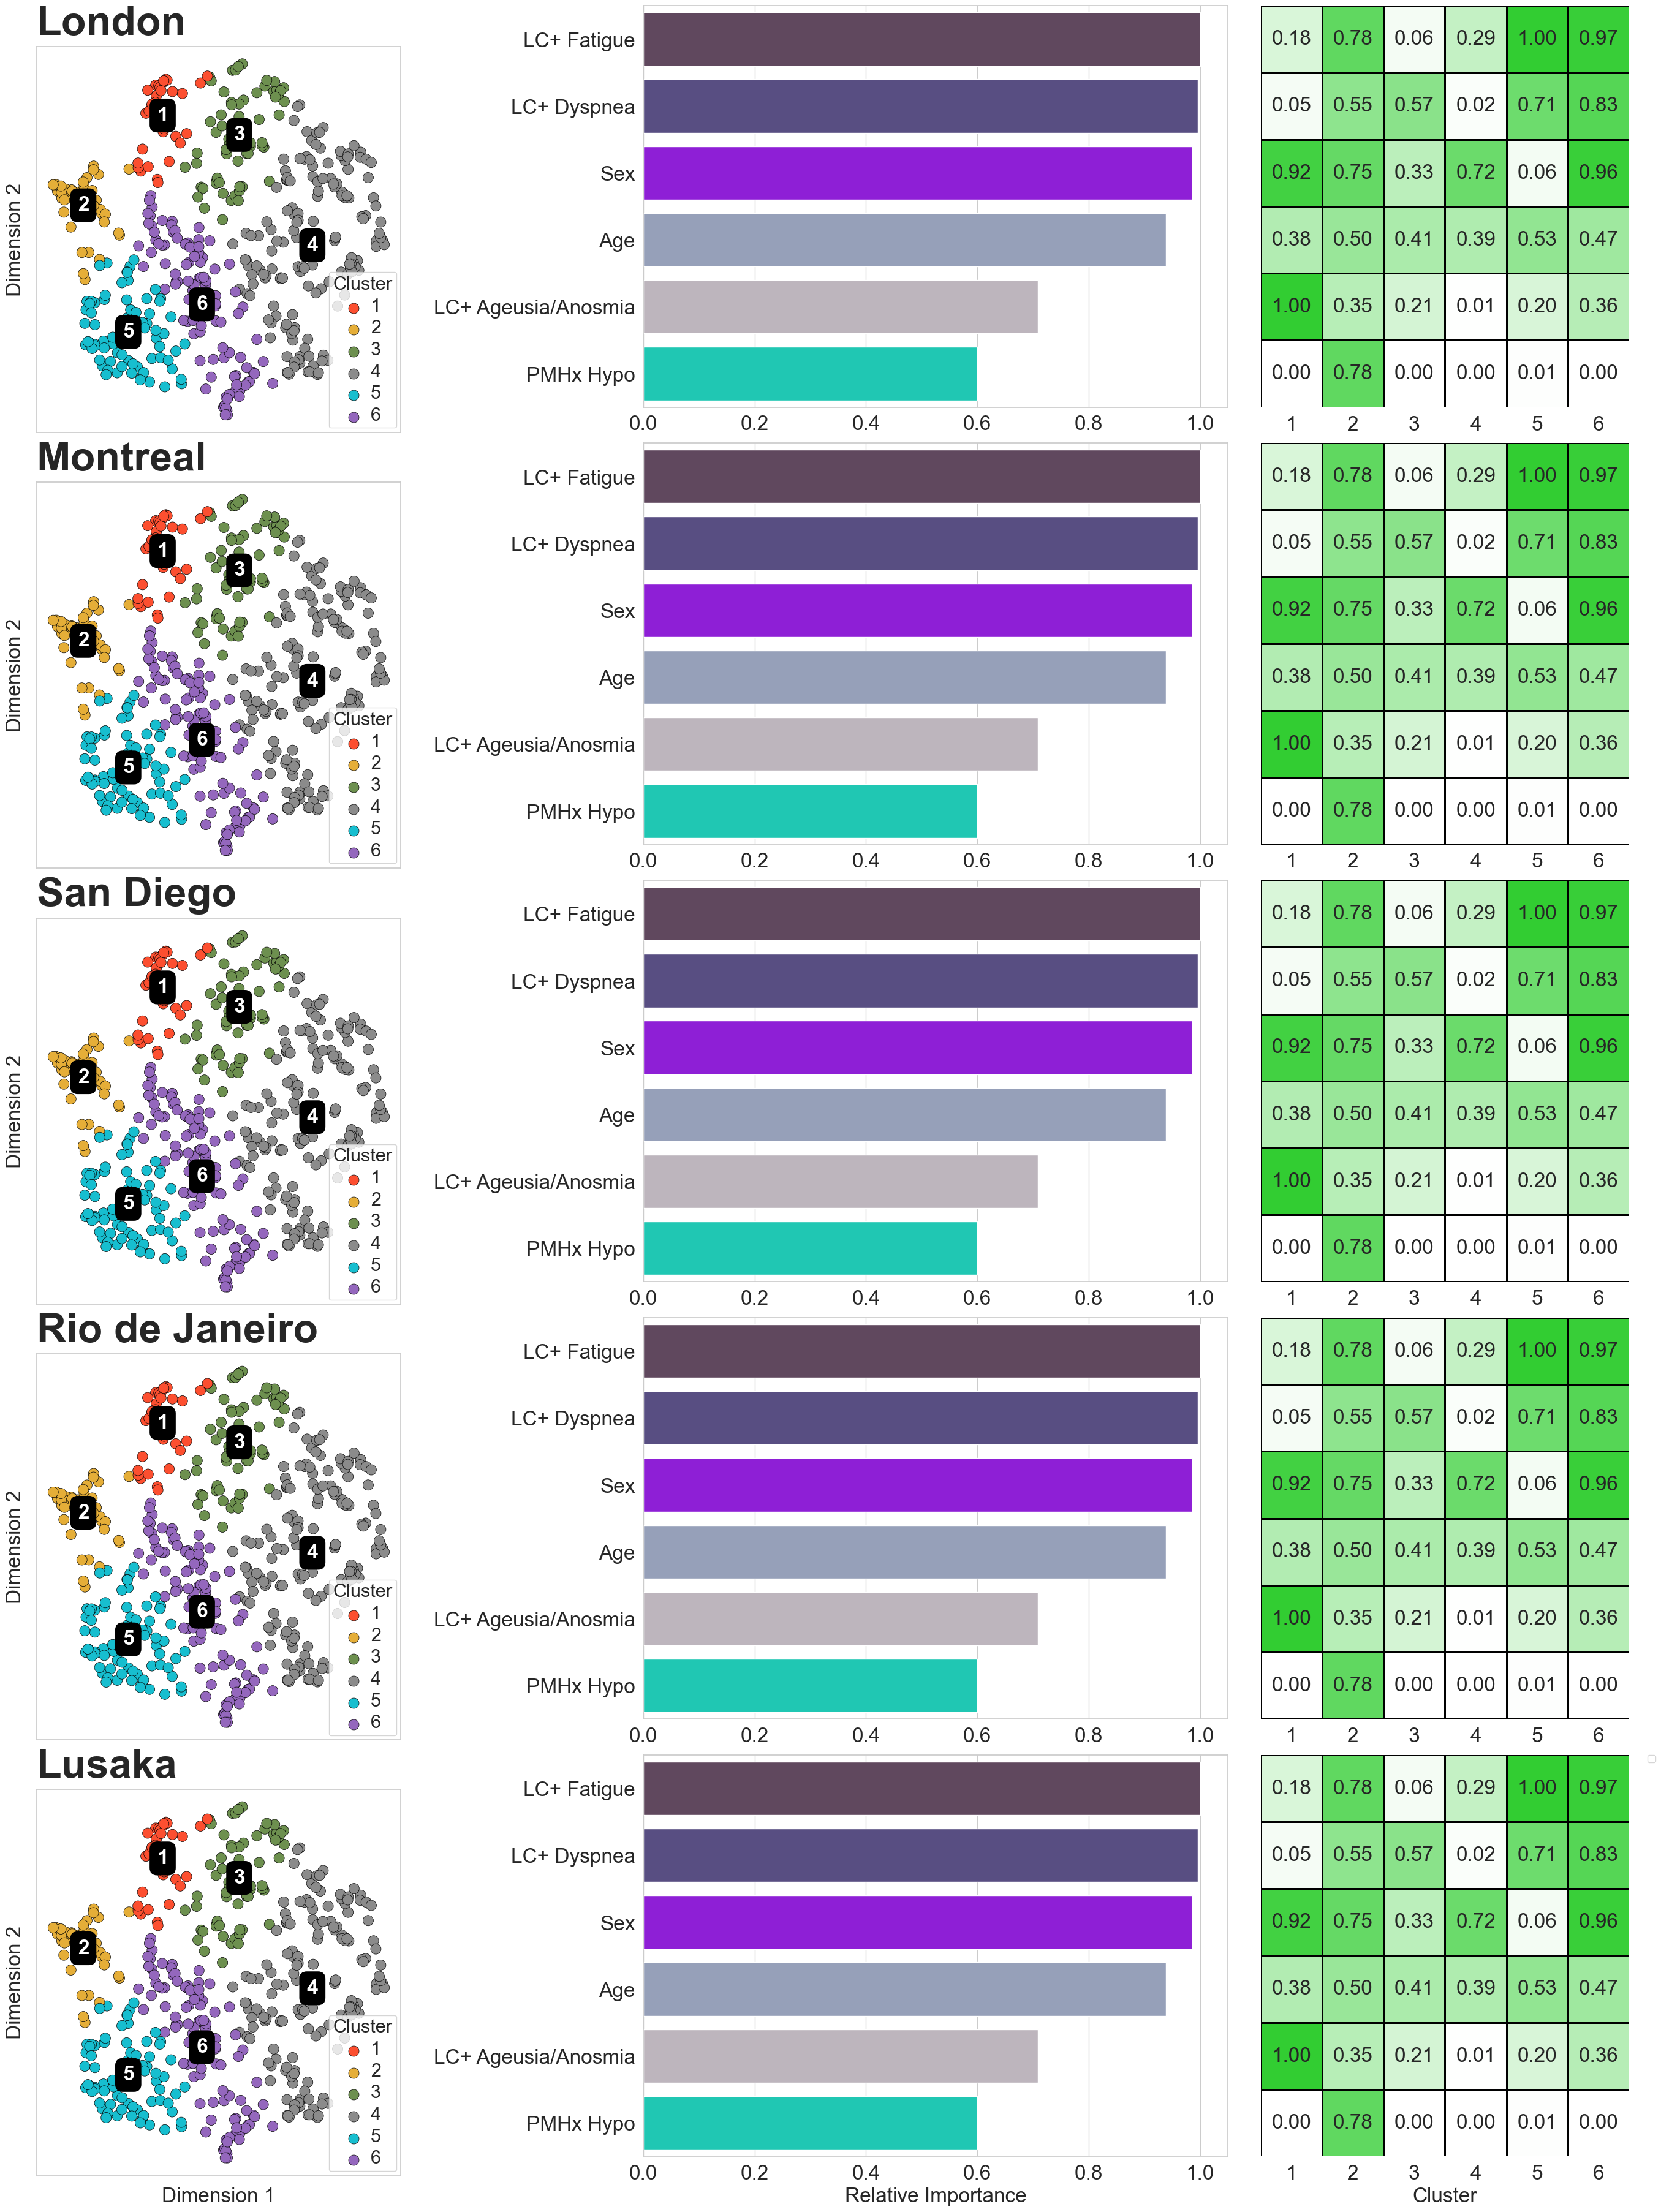

In [564]:
# make the figure

fig     = plt.figure(layout="constrained", figsize=(27,36), )
subfigs = fig.subfigures(1,3, wspace=0.05, hspace = 0.1, width_ratios=[1,2,1])

axl = subfigs[0].subplots(5, 1)
axc = subfigs[1].subplots(5, 1, sharex = False)
axr = subfigs[2].subplots(5, 1, sharex = False)

for i,item in enumerate(result_dict.items()):

    k, v = item

    plot_df            = v['plot_df']
    important_features = v['important_features']
    X                  = v['X']

    # clusters
    plot_clusters(plot_df, 
                  site_name_dict, 
                  palette_dict,
                  title        = None, 
                  centroids    = True, 
                  size_by_prob = False, 
                  ax           = axl[i], 
                  style        = None
                  )
    # turn off the x label
    axl[i].set_xlabel("", fontsize = FONTSIZE)

    # feature importances
    fi_df = make_feature_importance_df(v['classifier'], v['important_features'])
    # select only the top10 features
    features10 = make_topN_features(fi_df, 
                                    10, 
                                    feature_map, 
                                    feature_colour_map)

    plot_feature_importances(features10, 
                             feature_map, 
                             feature_colour_map, 
                             axc[i], 
                             FONTSIZE)

    # the mean feature values
    mfv = X[important_features].mean()

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()
    M = M[important_features]
    # # augment with cluster labels
    M["cluster"] = [c+1 for c in v['cluster_labels']]
    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()


    # sort the mfv columns by the order of the important features
    mfv = mfv[features10["OLD Feature"]]

    # print(features10["Feature"], features10["OLD Feature"])

    # print(mfv)

    # map the feature names to the new names
    mfv.columns = features10["Feature"]

    # heatmaps
    sns.heatmap(mfv.T,
                cmap = cmap, 
                # ax = ax, 
                cbar = False, 
                vmin = 0, 
                linewidth = 1, 
                # linewidth = 0.5, 
                square = False, 
                linecolor = 'k',
                annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24},
                ax = axr[i]
    )

    # turn off the y axis label
    axr[i].set_ylabel("", fontsize = FONTSIZE)

    # turn off y ticks
    axr[i].set_yticks([])

    #make tick labels larger
    axr[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    axr[i].set_xlabel("", fontsize = FONTSIZE)


    axl[i].annotate(f"{site_fullname_dict[k]}",
                        xy=(0.0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='left', 
                        verticalalignment='bottom',
                        fontweight = "bold",
                        )



axl[4].set_xlabel("Dimension 1", fontsize = FONTSIZE)
axr[4].set_xlabel("Cluster", fontsize = FONTSIZE)
axc[4].set_xlabel("Relative Importance", fontsize = FONTSIZE)

plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site-300.png", dpi = 300, bbox_inches = 'tight')
plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site-600.png", dpi = 600, bbox_inches = 'tight')


# By SYMPTOM Status
- new, worsening, etc

In [565]:

factor = 3

In [566]:
lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

In [567]:
# select only the features in new_and_worse
X = LC_pos_[lc_symptoms].copy()
print(X.shape)

# drop rows with missing values
X.dropna(inplace = True, axis = 0)
print(X.shape)

# drop rows with all zeros
# X = X.loc[(X != 0).any(axis = 1)]
print(X.shape)

(494, 28)
(494, 28)
(494, 28)


In [568]:
# drop certain features

# drop features that contain adjunctive
X = X.drop(columns = X.filter(regex = 'adjunctive').columns)

# drop features that contain "medication_received"
X = X.drop(columns = X.filter(regex = 'medication_received').columns)

# drop features that contain "type_of_care"
X = X.drop(columns = X.filter(regex = 'type_of_care').columns)

# drop features that contain "ventilatory_support_type"
X = X.drop(columns = X.filter(regex = 'ventilatory_support_type').columns)

print(X.shape)

(494, 28)


In [569]:
# cluster pipeline


min_cluster_size = int(np.sqrt(X.shape[0]))*factor

print(f"MCS = {min_cluster_size}")



hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples':      min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.5,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
                'min_dist':     0.25,
                # 'metric': 'cosine',
                # 'metric': 'hamming',
            }

# define the transformer
umap_transformer = UMAP(**umap_parms, verbose = True)
embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', embedding_model),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# get the dataframe and the labels
# sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

n_clust = max(cluster_labels)+1

MCS = 66
UMAP(min_dist=0.25, random_state=42, verbose=True)
Tue Jul 23 09:45:48 2024 Construct fuzzy simplicial set
Tue Jul 23 09:45:48 2024 Finding Nearest Neighbors
Tue Jul 23 09:45:48 2024 Finished Nearest Neighbor Search
Tue Jul 23 09:45:48 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jul 23 09:45:50 2024 Finished embedding


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


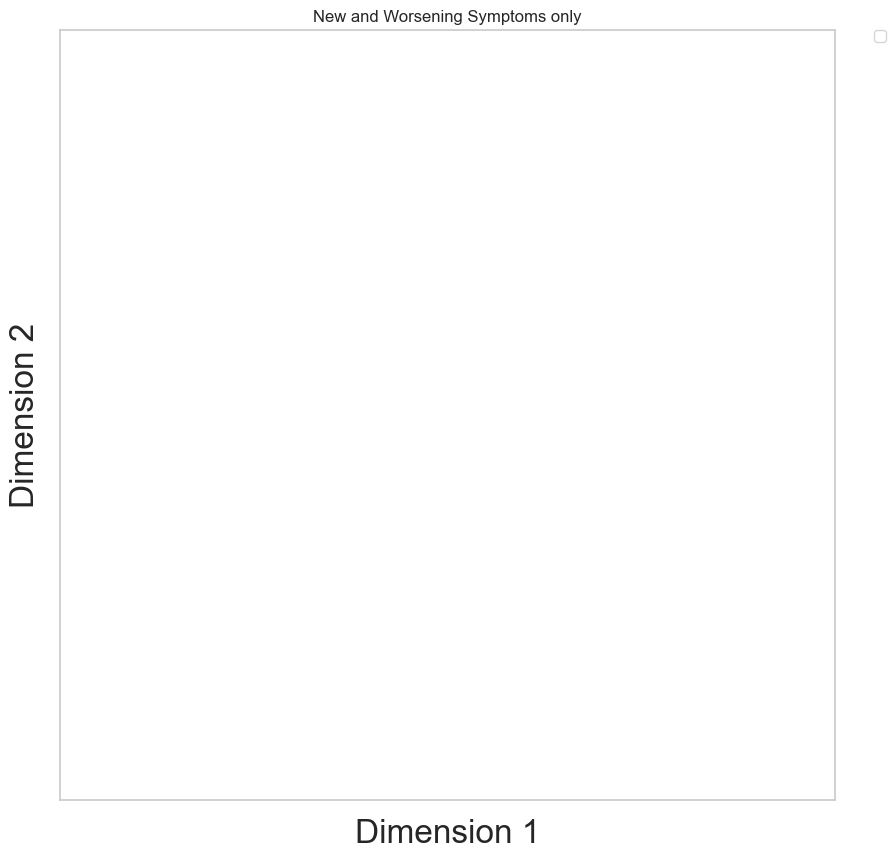

In [570]:
# plot the clusters
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = f"New and Worsening Symptoms only", 
              centroids = True, 
              size_by_prob = False, 
              ax = None,
              centroid_kws = {"alpha": 0.25, "palette_dict":None, "show_edge": False},)


In [571]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site

# divid by the row sum
cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

In [572]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/SYMPT_2-cluster-by-site-{n_clust}.tex")

KeyError: "None of [Index(['LDN', 'MTL', 'SAN', 'RIO', 'LUS'], dtype='object', name='Site')] are in the [index]"

In [439]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

# sort by the order in site_name_dict
cbsm = cbsm.loc[site_fullname_dict.values()]

cbsm

cluster            1     2
Site                      
London          65.5  34.5
Montreal        42.0  58.0
San Diego       19.2  80.8
Rio de Janeiro  44.8  55.2
Lusaka          10.3  89.7

In [440]:
# find important features

# classifier
clf2 = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# boruta
boruta = BorutaPy(clf2, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )

# fit, with the cluster_labels as targets
boruta.fit(X, cluster_labels)

# get the important features
important_features = X.columns[boruta.support_]

# now fit the classifier on these features
clf2.fit(X[important_features], cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100


BorutaPy finished running.

Iteration: 	23 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	19


RandomForestClassifier(max_depth=7, n_estimators=60, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x32AEA5B40)

In [441]:
# dataframes with the feature importance and topN features
fi_df = make_feature_importance_df(clf2, important_features)
top_features = make_topN_features(fi_df, 20, feature_map, feature_colour_map)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


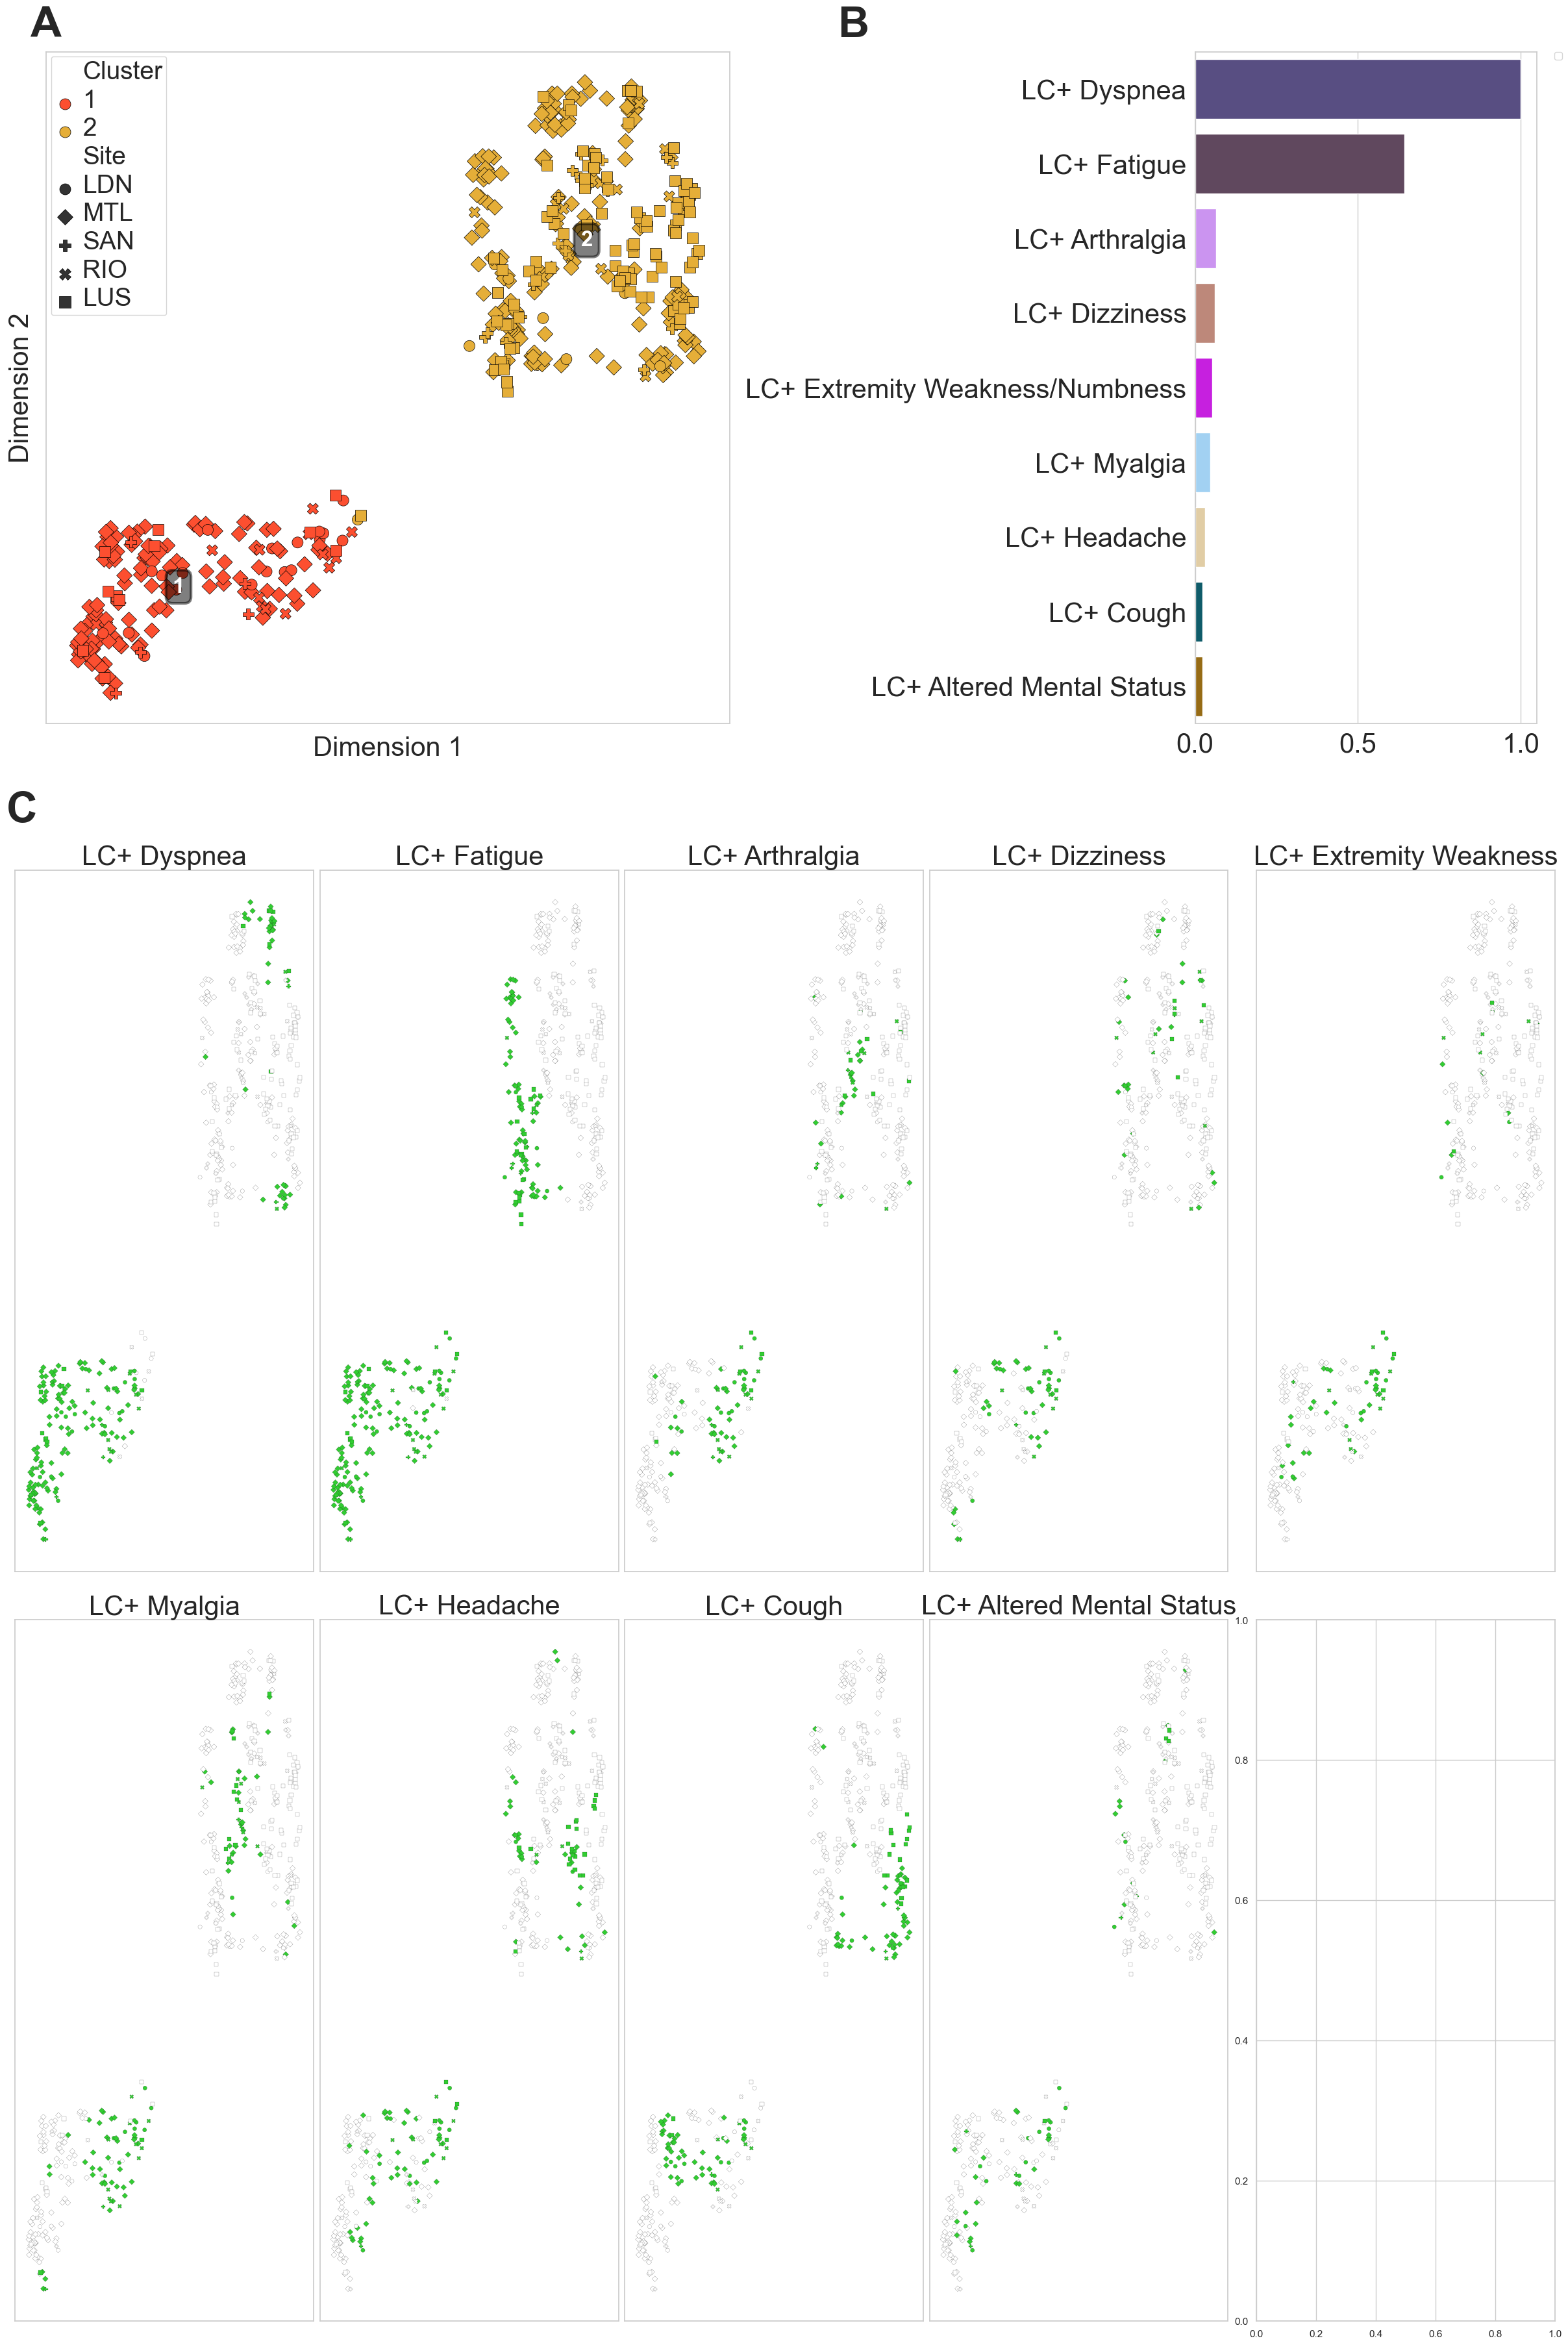

In [442]:
# plot

# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)
n_rows = int(np.ceil(n/5))

# h_factor = 

fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[1,2], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              ax = axs0[0],
              FONTSIZE = FONTSIZE*1.25,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": False},)
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


plot_feature_importances(top_features, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)

axs1 = subfigs[1].subplots(n_rows,5)

plot_multiple_features(fi_df, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        show_centroids = False,
                        fontsize = FONTSIZE*1.25,

                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:
    plt.savefig(f"{figdir}/SYMPT_2-only-feature-importances-300-{n_clust}.png", dpi = 300, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/SYMPT_2-only-feature-importances-600-{n_clust}.png", dpi = 600, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/SYMPT_2-only-ffeature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

In [443]:
fi_df

Feature  Importance
0  SYMPT-shortness_of_breath_dyspne___2    0.514658
1                     SYMPT-fatigue___2    0.330701
2       SYMPT-joint_pain_arthralgia___2    0.033568
3                   SYMPT-dizziness___2    0.031056
4  SYMPT-extremity_weakness_or_numb___2    0.027363
5        SYMPT-muscle_aches_myalgia___2    0.023870
6                    SYMPT-headache___2    0.015492
7                       SYMPT-cough___2    0.011723
8  SYMPT-confusion_altered_mental_s___2    0.011569

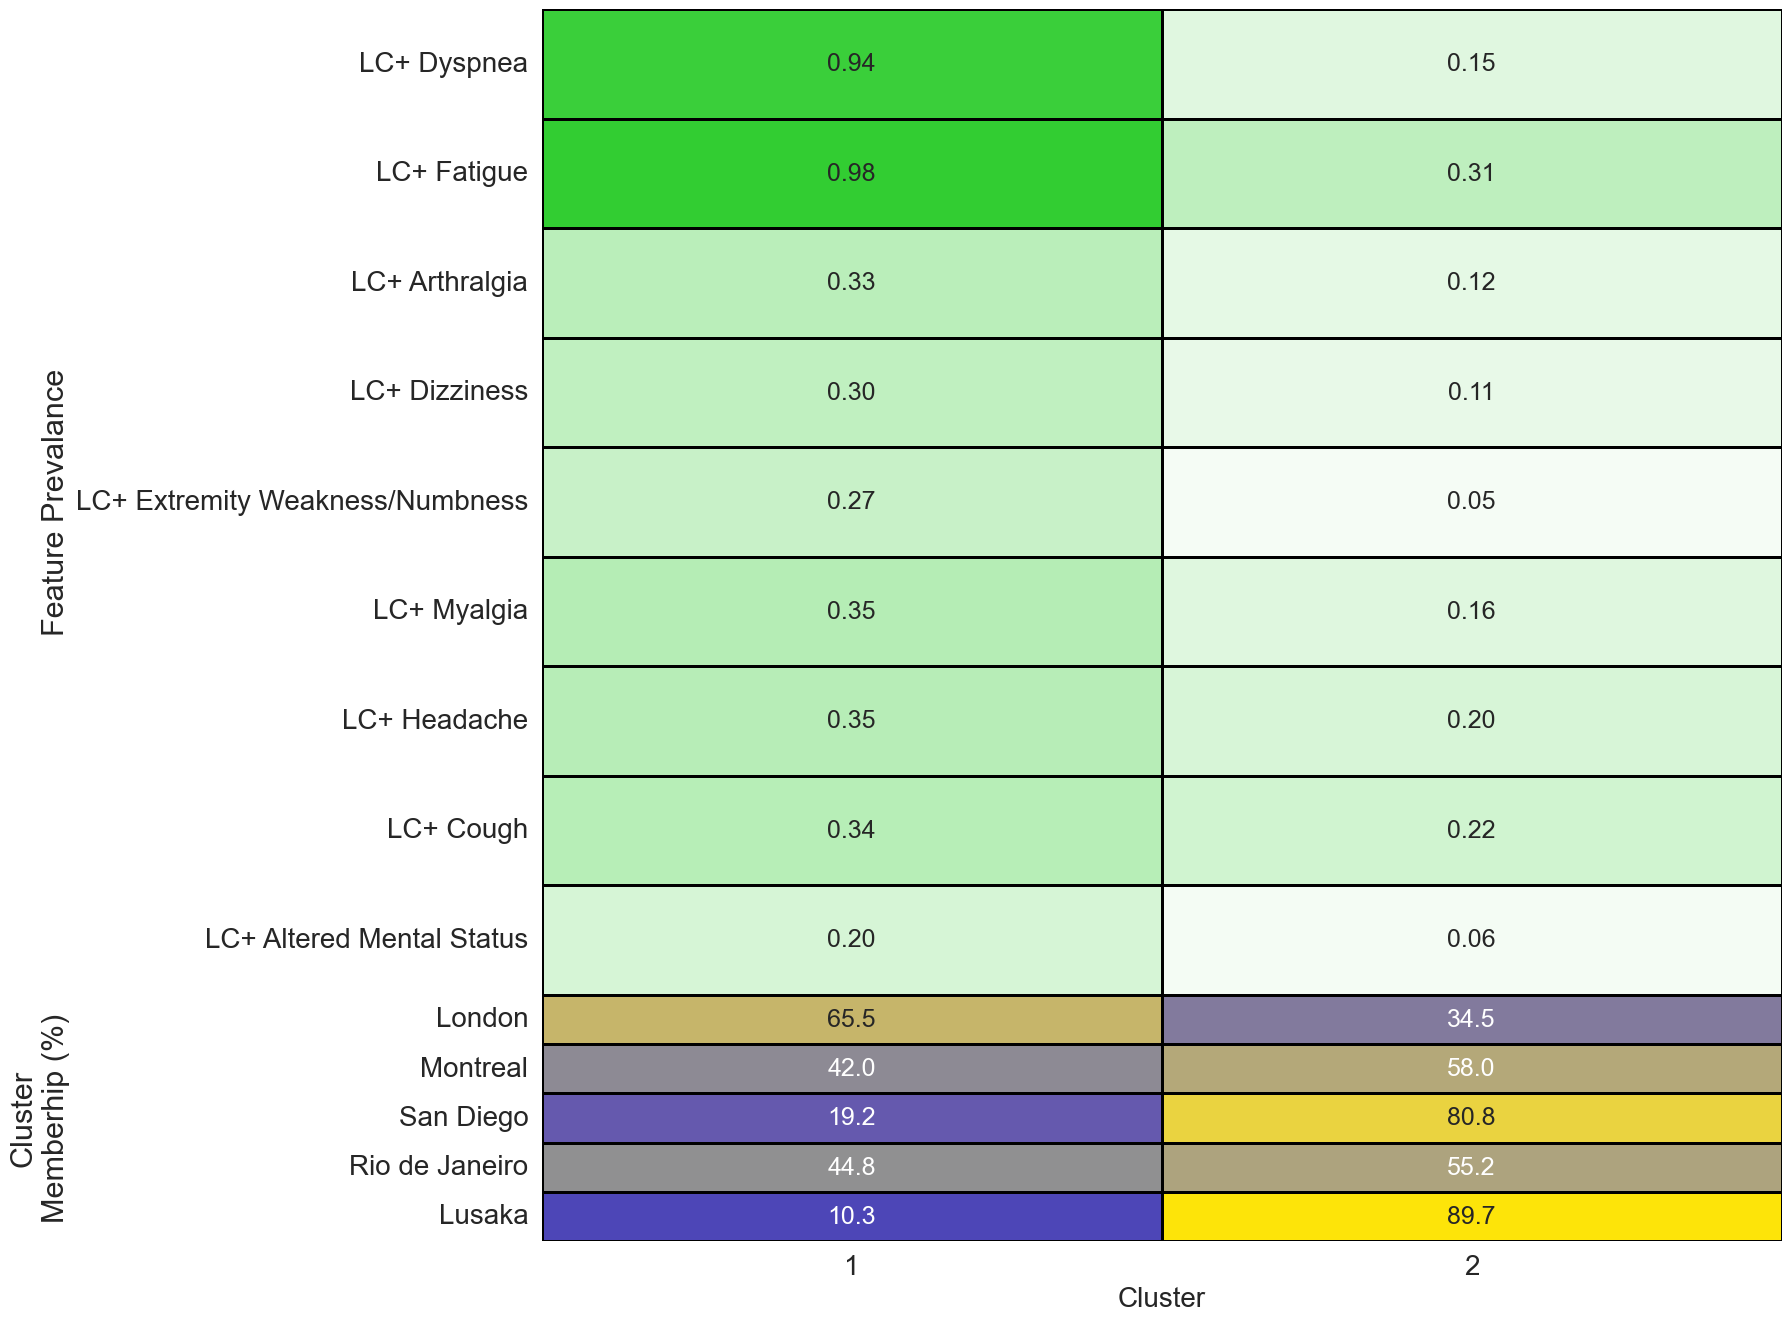

In [444]:
# heatmap of features by cluster
M = X.copy()
M = M[important_features]
M["cluster"] = [c+1 for c in cluster_labels]

# get the means
mfv = M.groupby("cluster").mean()

# sort the index by the order in fi_df
mfv = mfv[fi_df["Feature"]]

# transpose
mfv = mfv.T

# rename mfv index
mfv.index = mfv.index.map(feature_map)


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(16,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

# logscale the heatmap colour
# cmap = sns.color_palette("viridis", as_cmap = True)

from matplotlib.colors import LogNorm

sns.heatmap(mfv[:20], 
            cmap = cmap, 
            # norm = LogNorm(),
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            # norm = LogNorm(),
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
plt.savefig(f"{figdir}/SYMPT_2-only-feature-prevalence-by-cluster-600-{n_clust}.png", dpi = 600, bbox_inches = 'tight')
plt.savefig(f"{figdir}/SYMPT_2-only-feature-prevalence-by-cluster-300-{n_clust}.png", dpi = 300, bbox_inches = 'tight')

# picle mfv
mfv.to_pickle(f"./SYMPT_2-only-feature-prevalence-by-cluster.pkl")


In [445]:
# for each cluster in mfv, find the features that are > 0.3

# make a dataframe to hold the results

# make a dictionary to hold the results
rd = {}

# iterate over the columns in mfv

for c in mfv.columns:
    
        # sort the values in the column
        srt = mfv[c].copy()
        srt.sort_values(ascending = False, inplace = True)

        # print(srt)

        srt_grt = srt[srt > 0.3]


        if len(srt_grt) == 0:
            # get the top 3 features instead
            srt_grt = srt.nlargest(3)


        print(srt_grt.values)

        # get the feature names
        features = srt_grt.index
        values = srt_grt.values
    
        # strip the "LC+" from the feature names
        features = [f.replace("LC+ ", "") for f in features]

        if len(features) > 3:
                features = features[:3]
                values = values[:3]

                # set the last feature to "Other (diffuse)"
                features[-1] = "Others (diffuse)"

                # get the mean value of the other features

                vm = srt_grt.values[3:].mean()
                print(vm)


                # vm = 1

                values[-1] = vm

        # add to the dictionary
        rd.update({c: (features, values)})

# make a dataframe from the dictionary
rd_df2 = pd.DataFrame.from_dict(rd, orient = "index")



[0.98255814 0.94186047 0.35465116 0.34883721 0.34302326 0.33139535
 0.30232558]
0.33139534883720934
[0.3136646]


In [446]:
rd_df2.reset_index(inplace = True)
# rename the columns
rd_df2.columns = ["Cluster", "Feature", "Value"]
rd_df2

Cluster                               Feature  \
0        1  [Fatigue, Dyspnea, Others (diffuse)]   
1        2                             [Fatigue]   

                                               Value  
0  [0.9825581395348837, 0.9418604651162791, 0.331...  
1                               [0.3136645962732919]

In [447]:
# save rd_df2 to pickle
rd_df2.to_pickle(f"./SYMPT_2-rd_df2.pkl")

In [448]:
# B = X.copy()

# # augment with site labels
# # B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# new_symp = []

# # iterate over the columns in B, renaming those that are in feature_map
# for c in B.columns:
#     # print(c)
#     # print(list(feature_map.keys()))
#     if c in list(feature_map.keys()):
#         B.rename(columns = {c: feature_map[c]}, inplace = True)
#         new_symp.append(feature_map[c])

# # convert B to boolean
# B = B.astype(bool)

# B["Cluster"] = [c+1 for c in cluster_labels]

# # drop SITE
# # B = B.drop("SITE", axis = 1)

# # save the B dataframe
# # B.to_csv(f"{data_dir}/SYMPT_2-only_RECORDS.csv")



# # # load the B dataframe
# # B = pd.read_csv(f"{data_dir}/SYMPT_2-only_RECORDS.csv", index_col = 0)


# # fig, ax = plt.subplots(1,1, figsize = (16,16))

# us = UpSet(
#     from_indicators(["LC+ Fatigue", "LC+ Dyspnea", "LC+ Myalgia", "LC+ Ageusia/Anosmia", "LC+ Arthralgia", "LC+ Extremity Weakness/Numbness"], data = B),
#     # min_subset_size=100,
#     # max_subset_size=200,
#     intersection_plot_elements = 5,
#     max_subset_rank            = 10,
#     orientation                = "horizontal",
#     # show_counts                = True,
#     show_percentages           = True,
#     sort_by                    = "-degree",
#     sort_categories_by         = "-cardinality",
#     element_size               = 50,
#     # subset_size                = "count",
#     # sum_over                   = "Cluster",
# )

# colors = [cc.glasbey_hv[i] for i in set(B["Cluster"])]

# us.add_stacked_bars(by="Cluster", 
#                        title="Cluster", 
#                        elements=5, 
#                        colors = colors, 
#                        )

# # pr = us.plot(fig)

# us.plot()
# plt.show()

## TREEMAPS
TODO:
- [ ] automate the selection of the top 3 features per cluster
- [ ] build the treemap stuff

In [449]:
# for each cluster in mfv, find the features that are > 0.3

rd = {}

# iterate over the columns in mfv

for c in mfv.columns:
    
        # sort the values in the column
        srt = mfv[c].copy()
        srt.sort_values(ascending = False, inplace = True)

        # find the features that are > 0.3
        srt_grt = srt[srt > 0.3]

        # print(srt_grt)

        # if they are all < 0.3, get the top 3
        if len(srt_grt) == 0:
            # get the top 3 features instead
            srt_grt = srt.nlargest(3)

        # get the feature names
        features = srt_grt.index
    
        # strip the "LC+" from the feature names
        features = [f.replace("LC+ ", "") for f in features]

        # if there are more than 3 features, keep only the top 3
        if len(features) > 3:
                features = features[:3]

                # set the last feature to "Other (diffuse)"
                features[-1] = "Others (diffuse)"

        # add to the dictionary
        rd.update({c: features})

# make a dataframe from the dictionary
rd_df = pd.DataFrame.from_dict(rd, orient = "index")



In [450]:
# summarize cbs by total number of records per cluster
cbs2 = cbs.sum(axis = 0)/cbs.sum().sum()*100

cbs2 = pd.DataFrame(cbs2, columns = ["Fraction"])

# reset the index
cbs2.reset_index(inplace = True)


In [451]:
s1 = rd_df[0].to_list()
s2 = rd_df[1].to_list()
s3 = rd_df[2].to_list()

cbs2["s1"] = pd.Series(s1)
cbs2["s2"] = pd.Series(s2)
cbs2["s3"] = pd.Series(s3)

In [452]:
# add a column to cbs2 that counts the number of symptoms
cbs2["n"] = cbs2["s1"].apply(lambda x: 1 if x != None else 0) + cbs2["s2"].apply(lambda x: 1 if x != None else 0) + cbs2["s3"].apply(lambda x: 1 if x != None else 0)

# round fraction to 1 decimal place
cbs2["Fraction"] = cbs2["Fraction"].round(1)

In [453]:
cbs2["colour"] = [cc.glasbey_dark[i] for i in cbs2["n"]]

# change the value of colour if s3 contains diffuse
idx = cbs2.loc[cbs2["s3"] == "Others (diffuse)"] 

cbs2.loc[idx.index, "colour"] = "#dedbef"


for i, row in cbs2.iterrows():

    # label elements
    l1 = row["s1"]
    if row["s2"] == None:
        l2 = ""
    else:
        l2 = row["s2"]

    if row["s3"] == None:
        l3 = ""
    else:   
        l3 = row["s3"]

    lbl = f"Cluster {i+1}:\n{row['Fraction']:0.1f}%\n{l1}"
    if l2 != "":
        lbl += f"\n{l2}"
    if l3 != "":
        lbl += f"\n{l3}"

    cbs2.loc[i, "label"] = lbl



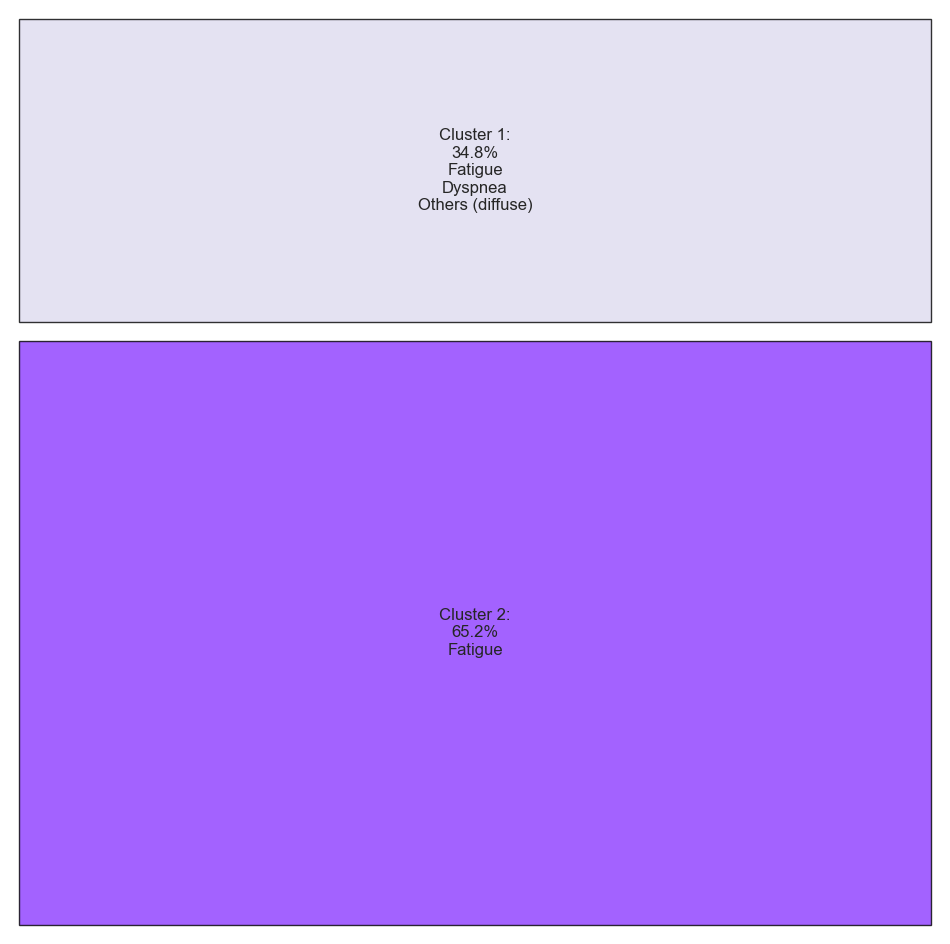

In [454]:
import squarify

fig, ax = plt.subplots(1, 1, figsize=(12,12))


squarify.plot(sizes = cbs2["Fraction"], 
              label = cbs2["label"], 
            #   value = cbs2["Fraction"], 
              alpha = 0.8, 
              color = cbs2["colour"], 
              edgecolor = "black", 
              pad = True, 
              ax = ax, 
              text_kwargs = {"fontsize": 12, "weight": "regular", 
                            #  "bbox": {"facecolor": "white", "alpha": 0.25}
                             }
              )
plt.axis('off')

# invert the y-axis
plt.gca().invert_yaxis()


plt.savefig(f"{figdir}/SYMPT_2-only-symptoms-TREEMAP-300-{n_clust}.png", dpi = 300, bbox_inches = 'tight')
plt.savefig(f"{figdir}/SYMPT_2-only-symptoms-TREEMAP-600-{n_clust}.png", dpi = 600, bbox_inches = 'tight')

In [455]:
cbs2

cluster  Fraction       s1       s2                s3  n   colour  \
0        1      34.8  Fatigue  Dyspnea  Others (diffuse)  3  #dedbef   
1        2      65.2  Fatigue     None              None  1  #8c3bff   

                                               label  
0  Cluster 1:\n34.8%\nFatigue\nDyspnea\nOthers (d...  
1                         Cluster 2:\n65.2%\nFatigue

In [456]:
data = []

rd_df2["Fraction"] = cbs2["Fraction"]

for i, row in rd_df2.iterrows():

    # print (i,row)

    cluster = row["Cluster"]
    features = row["Feature"]
    values = row["Value"]

    print(cluster, features, values)




    the_dict = {"id": f"Cluster {cluster}",
                "datum": row["Fraction"],
                }

    the_children = []

    for id,datum in zip(features, values):
            
            the_children.append({"id": id,
                                 "datum": datum,
                                })

    the_dict["children"] = the_children




    data.append(the_dict)
data

1 ['Fatigue', 'Dyspnea', 'Others (diffuse)'] [0.98255814 0.94186047 0.33139535]
2 ['Fatigue'] [0.3136646]


[{'id': 'Cluster 1',
  'datum': 34.8,
  'children': [{'id': 'Fatigue', 'datum': 0.9825581395348837},
   {'id': 'Dyspnea', 'datum': 0.9418604651162791},
   {'id': 'Others (diffuse)', 'datum': 0.33139534883720934}]},
 {'id': 'Cluster 2',
  'datum': 65.2,
  'children': [{'id': 'Fatigue', 'datum': 0.3136645962732919}]}]

In [457]:
# data = []


# for i, row in cbs2.iterrows():

#     the_dict = {"id": f"Cluster {i+1}",
#                 "datum": row["Fraction"],
#                 }

#     the_children = []

#     for j in range(1, 4):
            
#             if row[f"s{j}"] != None:
#                 the_children.append({"id": row[f"s{j}"], "datum": 1})
#             else:
#                  pass

#     the_dict["children"] = the_children




#     data.append(the_dict)

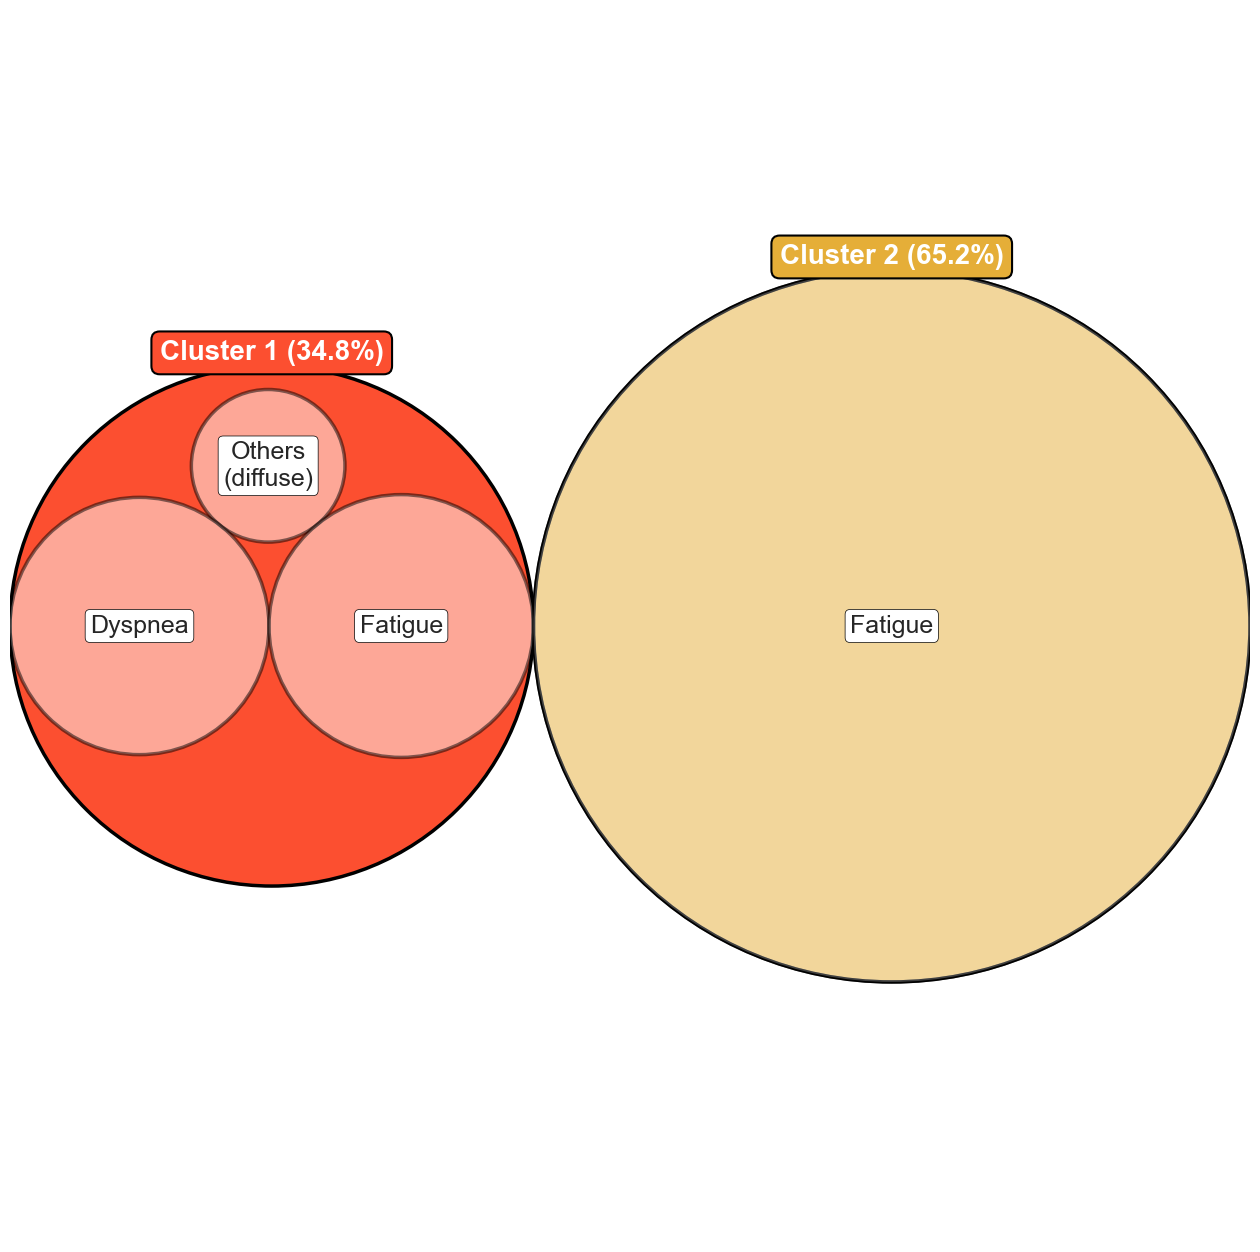

In [458]:
# data = [{"id": "Cluster 1", "datum": 10,
#                 'children': [
#                   {"id": "Fatigue", "datum": 1},
#                   {"id": "Dyspnea", "datum": 1}
#                         ]
#             },
#              {"id": "Cluster 2", "datum": 14,
#                 'children': [
#                   {"id": "Fatigue", "datum": 0.5},
#                   {"id": "", "datum": 0.01},
#                         ]
#              },
#              {"id": "Cluster 3", "datum": 19.6,
#               'children': [
#                   {"id": "Headache", "datum": 1.0},
#                   {"id": "Dizziness", "datum": 1.0},
#                   {"id": "Others (diffuse)", "datum": 1.0},
#               ]
#               },
#              {"id": "Cluster 4", "datum": 22.6,
#               'children':[
#                         {"id": "Dyspnea", "datum": 0.6},
#                         {"id": "Cough", "datum": 0.47},
#                         ]
#                         },
#              {"id": "Cluster 5", "datum": 24.5,
#                 'children': [
#                   {"id": "Myalgia", "datum": 0.84},
#                   {"id": "Arthralgia", "datum": 0.8},
#                   {"id": "Others (diffuse)", "datum": 1.0},
#                         ]
#               },
#              {"id": "Cluster 6", "datum": 9.3,
#                 'children': [
#                   {"id": "Fatigue", "datum": 0.99},
#                   {"id": "Alt. Mental Status", "datum": 0.93},
#                   {"id": "Others (diffuse)", "datum": 0.5},
#                         ]},
#          ]
import circlify
circles = circlify.circlify(data, show_enclosure=False)



# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(16, 16))

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# print circles
for i, circle in enumerate(circles):

    # print(i, )

    x, y, r = circle

    if circle.level == 0:
        pass


    else:

        try:
            circ_n     = circle.ex["id"].split(" ")[1]
            face_color = cc.glasbey_hv[int(circ_n)]
            face_alpha = 1.0
        except:
            face_color = "grey"


        # how many children?
        try:
            n_children = len(circle.ex["children"])
            the_color = cc.glasbey_dark[n_children]
            # the_color =  "white"
            the_alpha = 1.0
            the_color   =        cc.glasbey_hv[int(circ_n)]
        except:
            n_children = 0
            the_color = "white"
            the_alpha = 0.5
            # the_color = "black"
            # the_color = face_color
            # r = 0.8*r

        # if n_children  == 1:
        #     # scale the radius

        #     r = r*0.8


        ax.add_patch(plt.Circle(
                                (x, y), 
                                r, 
                                alpha=the_alpha, 
                                # alpha=0.5, 
                                fill=True, 
                                # facecolor=cc.glasbey_hv[i], 
                                facecolor=the_color, 
                                # edgecolor = "black",
                                # ec = the_color,
                                ec = "black",
                                lw = 2.5,
                                # edgewidth = 2.5,
                                )
                            )
    # how many children?
    # try:
    #     n_children = len(circle.ex["children"])
    # except:
    #     n_children = 0

    # if circle.level == 1:
    #     ax.text(x, y, circle.ex["id"], ha='center', va='center', fontsize=12)

    if circle.level == 1:

        circ_n = circle.ex["id"].split(" ")[1]
        face_color = cc.glasbey_hv[int(circ_n)]

        # r,g,b = face_color
        # print(r,g,b)

        # get the luminance of the face color

        # lum = 

        # face_luminance = cc.luminance(face_color)

        lbl1 = f"{circle.ex['id']} ({circle.ex['datum']}%)"

        ax.text(x, y+(r*1.0),
                lbl1, 
                ha='center', 
                va='bottom', 
                fontsize=20,
                color = "white", 
                # make text bold
                fontweight = "bold",
                bbox=dict(
                    facecolor=face_color,
                    # facecolor='white', 
                    edgecolor='black', 
                    boxstyle='round', 
                    pad=0.3,
                    linewidth = 1.5))    

    if circle.level == 2:

        lbl = circle.ex["id"]
        wt = circle.ex["datum"]

        # if there is a /, split and bnewling
        if "/" in lbl:
            lbl = lbl.split("/")[0] + "/\n" + lbl.split("/")[1]

        # lbl += f"\n{wt:0.2f}"

        # # split on second space for long labels
        # try:
        #     ss = str.split(lbl, " ", 2)
        #     lbl = ss[0] + " " + ss[1] + "\n" + ss[2]
            
            
        # except:
        #     pass

        # split on spaces and replace with newlines
        lbl = lbl.replace(" ", "\n")
        




        ax.annotate(
                    lbl,
                     (x,y), 
                    ha='center', 
                    va='center', 
                    # rotation = 3.14,
                    # annotation_clip = True,
                    bbox=dict(
                                facecolor='white', edgecolor='black', boxstyle='round', pad=.2, 
                                # alpha = 0.75, 
                                alpha = 1.0, 
                                linewidth = 0.5), 
                    fontsize = 18)

plt.savefig(f"{figdir}/SYMPT_2-only-symptoms-CIRCLE-300-{n_clust}.png", dpi = 300, bbox_inches = 'tight')
plt.savefig(f"{figdir}/SYMPT_2-only-symptoms-CIRCLE-600-{n_clust}.png", dpi = 600, bbox_inches = 'tight')

plt.show()